# Detection of anomalies with possible localization (Model II) 👾

# Imports ♻

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.models as models
from torchvision import transforms
import glob
import os
from torchsummary import summary
from google.colab import drive
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2
import torchvision.datasets as datasets
import random
import math
from tqdm import tqdm


drive.mount('/content/drive')

Mounted at /content/drive


# Model 🏛

In [ ]:
class CCM(nn.Module):
    """
    Convex Combination Module (CCM) as described in Section 3.3 and Figure 6.
    It computes a mask beta to combine the skip connection (x_s) and the
    current decoder feature map (x_c).
    """
    def __init__(self, in_channels):
        super(CCM, self).__init__()
        # Input to the coefficient network is concatenation of:
        # x_s, x_c, and (x_s - x_c)^2
        # So input channels = in_channels * 3
        self.coeff_conv1 = nn.Sequential(
            nn.Conv2d(in_channels * 3, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        self.coeff_conv2 = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x_s, x_c):
        """
        x_s: Feature map from Encoder (Skip connection)
        x_c: Feature map from current Decoder layer
        """
        # Ensure dimensions match (sometimes needed due to padding issues in autoencoders)
        if x_s.size() != x_c.size():
            x_c = F.interpolate(x_c, size=x_s.shape[2:], mode='bilinear', align_corners=True)

        # 1. Compute squared difference
        diff_sq = torch.pow(x_s - x_c, 2)

        # 2. Stack [x_s, x_c, diff_sq] along channel dimension
        combined = torch.cat([x_s, x_c, diff_sq], dim=1)

        # 3. Compute coefficient matrix beta
        out = self.coeff_conv1(combined)
        beta = self.coeff_conv2(out) # Shape: [B, 1, H, W]

        # 4. Convex combination: beta * x_s + (1 - beta) * x_c
        # Broadcast beta across channels
        return beta * x_s + (1 - beta) * x_c

class SDCBlock(nn.Module):
    def __init__(self, in_channels=256, branch_channels=64):
        super(SDCBlock, self).__init__()

        # The dilation rates specified in the paper (Table 1 & Section 3.3)
        dilations = [1, 2, 4, 8, 16, 32]

        self.branches = nn.ModuleList()

        # Create 6 parallel branches
        for d in dilations:
            self.branches.append(
                nn.Sequential(
                    # Each branch takes the input and produces 'branch_channels' (64)
                    # Padding must equal dilation to keep spatial size constant (H x W)
                    nn.Conv2d(in_channels, branch_channels, kernel_size=3,
                              padding=d, dilation=d, bias=False),
                    nn.BatchNorm2d(branch_channels),
                    nn.ReLU(inplace=True)
                )
            )

        # The total output channels after stacking 6 branches of 64
        # 64 * 6 = 384 channels
        stacked_channels = branch_channels * len(dilations)

        # Convolutional layers after the stack
        self.final_conv = nn.Sequential(
            nn.Conv2d(stacked_channels, stacked_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(stacked_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # 1. Run all dilated convolutions in parallel
        branch_outputs = [branch(x) for branch in self.branches]

        # 2. Stack (concatenate) them along the channel dimension
        # Output shape: [Batch, 384, H, W]
        stacked = torch.cat(branch_outputs, dim=1)

        # 3. Apply the final mixing convolution
        out = self.final_conv(stacked)

        return out

class AutoEncoder(nn.Module):
    def __init__(self, input_channels=3):
        super(AutoEncoder, self).__init__()

        # --- ENCODER ---
        # Block 1
        self.enc1_1 = nn.Sequential(nn.Conv2d(input_channels, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True))
        self.enc1_2 = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True))
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2
        self.enc2_1 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(True))
        self.enc2_2 = nn.Sequential(nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(True))
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3
        self.enc3_1 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(True))
        self.enc3_2 = nn.Sequential(nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(True))
        self.pool3 = nn.MaxPool2d(2, 2)

        # --- BOTTLENECK (SDC Blocks) ---
        # 1. The first block takes 256 input channels (from encoder)
        #    and outputs 384 (6 branches * 64 filters).
        # 2. Subsequent blocks take 384 input channels and output 384.
        self.bottleneck = nn.Sequential(
            # Input: 256 -> Branches: 64 each -> Stack: 384 -> Output: 384
            SDCBlock(in_channels=256, branch_channels=64),

            # Input: 384 -> Branches: 64 each -> Stack: 384 -> Output: 384
            SDCBlock(in_channels=384, branch_channels=64),
            SDCBlock(in_channels=384, branch_channels=64),
            SDCBlock(in_channels=384, branch_channels=64)
        )

        # --- DECODER ---
        # Block 3 (Matches Enc Block 3)
        self.upconv3 = nn.ConvTranspose2d(384, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.ccm3 = CCM(256)
        self.dec3_1 = nn.Sequential(nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(True))
        self.dec3_2 = nn.Sequential(nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(True))

        # Block 2 (Matches Enc Block 2)
        # Note: Input is 256 from Dec3, output should be 128
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.ccm2 = CCM(128)
        self.dec2_1 = nn.Sequential(nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(True))
        self.dec2_2 = nn.Sequential(nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(True))

        # Block 1 (Matches Enc Block 1)
        # Input 128, Output 64
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.ccm1 = CCM(64)
        self.dec1_1 = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True))
        self.dec1_2 = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True))

        # Output
        self.final_conv = nn.Conv2d(64, input_channels, kernel_size=1)
        # Paper mentions Sigmoid at the end (output is [0,1])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        # Block 1
        e1 = self.enc1_1(x)
        e1 = self.enc1_2(e1)
        p1 = self.pool1(e1)

        # Block 2
        e2 = self.enc2_1(p1)
        e2 = self.enc2_2(e2)
        p2 = self.pool2(e2)

        # Block 3
        e3 = self.enc3_1(p2)
        e3 = self.enc3_2(e3)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        # Block 3
        d3 = self.upconv3(b)
        # CCM merge: e3 is the skip connection, d3 is current decoder features
        d3_merged = self.ccm3(e3, d3)
        d3 = self.dec3_1(d3_merged)
        d3 = self.dec3_2(d3)

        # Block 2
        d2 = self.upconv2(d3)
        d2_merged = self.ccm2(e2, d2)
        d2 = self.dec2_1(d2_merged)
        d2 = self.dec2_2(d2)

        # Block 1
        d1 = self.upconv1(d2)
        d1_merged = self.ccm1(e1, d1)
        d1 = self.dec1_1(d1_merged)
        d1 = self.dec1_2(d1)

        # Output
        out = self.final_conv(d1)
        out = self.sigmoid(out)

        return out

# Determine device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Standard MVTec capsule image size is typically resized to 256x256
model = AutoEncoder(input_channels=3).to(device)
dummy_input = torch.randn(1, 3, 256, 256).to(device)
output = model(dummy_input).to(device)

print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)

#Model summary
summary(model, (3,256,256))

Using device: cuda
Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256

# Dataset 📚

**IMPORTANT** 📢

Set the **extract_path** variable to the folder containing the dataset in your Google Drive so that the project can run in your session.

In [ ]:
# Define the directory where you want to extract the files
# Fernando:
#extract_path = '/content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/'

size = 256
# Others:
extract_path = '/content/drive/MyDrive/Project/E-Code/'

# Choose training category, f.eks. "bottle", "capsule", "grid", ...
category = "capsule"

# Construct the full path to the 'capsule' dataset directory
test_dir = os.path.join(extract_path, category+"/"+category+"/test")
train_dir = os.path.join(extract_path, category+"/"+category+"/train")

# Initialize an empty list to store test image paths
test_list = []
train_list = []

# Recursively find all image files (png, jpg, jpeg) within the 'test' directory
for ext in ('*.png', '*.jpg', '*.jpeg'):
    test_list.extend(glob.glob(os.path.join(test_dir, '**', ext), recursive=True))
    train_list.extend(glob.glob(os.path.join(train_dir, '**', ext), recursive=True))

print(f"- Found {len(test_list)} test images.")
print(f"- Found {len(train_list)} train images.")

- Found 132 test images.
- Found 219 train images.


## Train Dataset

In [ ]:
# TRAIN DATASET
# Used to create the train_list and val_list
class MVTecDataset(Dataset):
    def __init__(self, file_list, transform=None):
      """
      file_list: a list of paths to images, e.g. the good-path for phase1, normal_train_images
      transform=resize, ToTensor, normalize, in training: image_train_transforms, image_val_transforms
      """
      self.file_list = file_list
      self.transform = transform

    def __len__(self):
      return len(self.file_list) #number of samples=length of file-list

    def __getitem__(self, idx):
      image_path = self.file_list[idx] #find path to image

      image = Image.open(image_path).convert("RGB") #open image

      if self.transform is not None:
        image=self.transform(image) #transform image

      return image


### Image transforms

In [ ]:
image_train_transforms = transforms.Compose([
    transforms.Resize((size,size)),
    # --- ADDED AUGMENTATIONS ---
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), #for domain-shift
    #transforms.RandomResizedCrop(size=(size, size), scale=(0.85, 1.0), ratio=(1.0, 1.0)), #for domain-shift
    transforms.RandomRotation(degrees=3, fill=200),
    #transforms.GaussianBlur(kernel_size=3), DELETE?
    # ---------------------------
    transforms.ToTensor(),

])

#normalizing and maybe resizing validation images ADD DOMAIN_SHIFT?
image_val_transforms = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.ToTensor(),

])

### Train Dataloader

Split ratio recommendations:

- 80/20: Standard baseline for MVTec.Robust threshold calibration.
- 90/10 or 95/5: Small datasets (<100 images) Maximizes model exposure to normal features.


In [ ]:
#split the list of normal images
train_list, val_list=train_test_split(train_list,
                                      test_size=0.05,
                                      random_state=42,
                                      shuffle=True)
#check
print("Number of training images", len(train_list))
print("Number of validation images", len(val_list))

#make dataset-objects

train_data=MVTecDataset(train_list, transform=image_train_transforms)
val_data=MVTecDataset(val_list, transform=image_val_transforms)

Number of training images 208
Number of validation images 11


In [ ]:
batch_size=4 #@param {type:"slider", min:1, max:20}

train_loader=DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True #for training

)

val_loader=DataLoader(
    dataset=val_data,
    batch_size=1,
    shuffle=False #for validation
)

print("Number of batches(train):", len(train_loader))
print("Number of batches(val):", len(val_loader))

Number of batches(train): 52
Number of batches(val): 11


Shape of image: torch.Size([3, 256, 256])


(np.float64(-0.5), np.float64(999.5), np.float64(999.5), np.float64(-0.5))

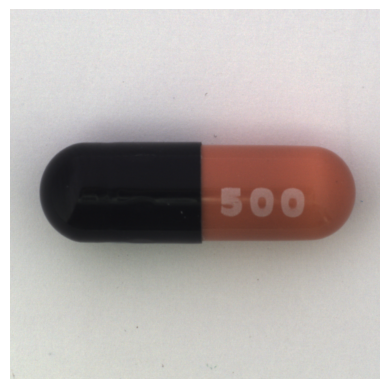

In [ ]:
# Get a single element from the train_dataset
image = train_data[0]

random_image_path = train_list[2]
img = Image.open(random_image_path)

# Print the shape of the image and the label
print(f"Shape of image: {image.shape}")
plt.imshow(img)
plt.axis("off")

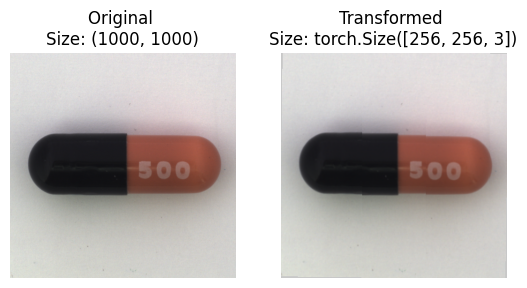

In [ ]:
def image_transformation_plot(image_path: str, transform: transforms.Compose) -> None:
    """
    Plots and compares selected image before and after transformation.

    Args:
        image_path (Path): Path of image to plot
        transform (Pytorch Transforms): Selected transforms composition
    """
    f = Image.open(image_path)

    fig, ax = plt.subplots(1, 2)
    plt.gray()
    ax[0].imshow(f)
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")

    transformed_image = transform(f).permute(1, 2, 0)
    ax[1].imshow(transformed_image)
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

image_transformation_plot(random_image_path, image_train_transforms)

## Test dataset

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

#used to create the train_list and val_list
class MVTecDatasetTest(Dataset):
    def __init__(self, file_list, transform=None):
      """
      file_list: a list of paths to images, e.g. the good-path for phase1, normal_train_images
      transform=resize, ToTensor, normalize, in training: image_train_transforms, image_val_transforms
      """

      self.file_list = file_list
      self.transform = transform

    def __len__(self):
      return len(self.file_list) #number of samples=length of file-list

    def __getitem__(self, idx):
      image_path = self.file_list[idx] #find path to image

      image = Image.open(image_path).convert("RGB") #open image

      # Determine label based on filename (simple approach for this dataset)
      label = 0 if 'good' in image_path else 1 # 1 for anomaly, 0 for good images

      if self.transform is not None:
        image=self.transform(image) #transform image

      return image, label, image_path

In [ ]:
# Normalizing and maybe resizing test images (normal test-data)
image_test_transforms = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.ToTensor(),
    #transforms.Normalize(mvtec_mean, mvtec_std)
])

In [ ]:
test_data=MVTecDatasetTest(test_list, transform=image_test_transforms)

test_loader=DataLoader(
    dataset=test_data,
    batch_size=1,
    shuffle=False #for validation
)

In [ ]:
# Get a single element from the train_dataset
image, label, _ = test_data[0]

# Print the shape of the image and the label
print(f"Shape of image: {image.shape}")
print(f"Shape of label: {label}")

Shape of image: torch.Size([3, 256, 256])
Shape of label: 1


# Training (Phase 1) 💪

## Anomaly Augmentator

In [ ]:
# Download and Load DTD (Train split is sufficient for textures)
# We don't apply resizing transforms here because we handle it dynamically in the augmentor
dtd_dataset = datasets.DTD(root='./data', split='train', download=True, transform=None)

print(f"DTD Dataset Loaded: {len(dtd_dataset)} textures available.")

100%|██████████| 625M/625M [00:02<00:00, 229MB/s]


DTD Dataset Loaded: 1880 textures available.


In [ ]:
class AnomalyAugmentor:
    def __init__(self, dtd_dataset, image_size=(256, 256)):
        self.dtd_dataset = dtd_dataset
        self.h, self.w = image_size

    def generate_soft_mask_patch(self, patch_size):
        """
        Creates a 'harder' soft mask.
        Keeps edges smooth but makes the core fully opaque (aggressive).
        """
        ph, pw = patch_size

        while True:
            # 1. Base Disk
            Y, X = np.ogrid[:ph, :pw]
            center = (ph // 2, pw // 2)
            radius = min(ph, pw) // random.randint(3, 4) # Slightly larger base radius
            dist_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)

            disk_mask = np.clip(1 - (dist_from_center / radius), 0, 1)

            # 2. Organic Noise
            noise_scale = random.choice([2, 4]) # Coarser noise for chunkier defects
            noise_res = (max(ph//noise_scale, 2), max(pw//noise_scale, 2))

            noise = np.random.uniform(0, 1, noise_res).astype(np.float32)
            smooth_noise = cv2.resize(noise, (pw, ph), interpolation=cv2.INTER_CUBIC)

            # 3. Combine & Aggressively Sharpen
            organic_mask = disk_mask * smooth_noise

            # AGGRESSIVE CHANGE:
            # Push values closer to 1.0 faster to make defect solid.
            # (x - 0.1) * 4.0 pushes anything above 0.35 to fully opaque 1.0
            organic_mask = (organic_mask - 0.1) * 4.0
            organic_mask = np.clip(organic_mask, 0, 1)

            if np.sum(organic_mask) > 20.0:
                return np.expand_dims(organic_mask, axis=-1)

    def blend_texture_color(self, texture, target_region):
        """
        Modified for Aggressiveness:
        Prioritizes the anomaly's OWN color over the background color.
        """
        # 50% chance to do NO blending (pure foreign object)
        if random.random() < 0.5:
            return texture

        t_mean = np.mean(texture, axis=(0, 1))
        t_std = np.std(texture, axis=(0, 1)) + 1e-6

        target_mean = np.mean(target_region, axis=(0, 1))
        target_std = np.std(target_region, axis=(0, 1))

        adjusted = (texture - t_mean) * (target_std / t_std) + target_mean
        adjusted = np.clip(adjusted, 0, 1)

        # AGGRESSIVE CHANGE:
        # Blend strength is lower (0.0 to 0.4).
        # 0.0 = Pure Texture, 1.0 = Pure Background Match.
        # We keep it low so it stands out.
        blend_strength = random.uniform(0.0, 0.4)

        final_texture = (1 - blend_strength) * texture + blend_strength * adjusted
        return final_texture

    def augment(self, image_tensor):
        img = image_tensor.permute(1, 2, 0).cpu().numpy()
        global_mask = np.zeros((self.h, self.w, 1), dtype=np.float32)
        augmented_img = img.copy()

        # AGGRESSIVE CHANGE: More patches (2 to 5)
        target_patches = random.randint(2, 5)
        patches_placed = 0
        attempts = 0
        max_attempts = 100

        # --- ROI DEFINITION (CENTER STRIP) ---
        # Restrict Y to the middle 50% of the image (Capsule Location)
        min_y = int(self.h * 0.10)
        max_y = int(self.h * 0.90)

        # X can still be mostly full width, but avoiding extreme edges
        min_x = int(self.w * 0.05)
        max_x = int(self.w * 0.95)

        while patches_placed < target_patches and attempts < max_attempts:
            attempts += 1

            # AGGRESSIVE CHANGE: Larger patches (up to 35% of height)
            p_size = random.randint(int(self.h * 0.15), int(self.h * 0.35))

            safe_max_x = max(min_x, max_x - p_size)
            safe_max_y = max(min_y, max_y - p_size)

            if safe_max_x <= min_x or safe_max_y <= min_y:
                continue

            left = random.randint(min_x, safe_max_x)
            top = random.randint(min_y, safe_max_y)

            # Generate Data
            roi = augmented_img[top:top+p_size, left:left+p_size]

            patch_mask = self.generate_soft_mask_patch((p_size, p_size))
            texture = self.load_random_texture(p_size)
            texture_blended = self.blend_texture_color(texture, roi)

            # Apply
            roi_augmented = (patch_mask * texture_blended) + ((1 - patch_mask) * roi)

            augmented_img[top:top+p_size, left:left+p_size] = roi_augmented

            current_mask_roi = global_mask[top:top+p_size, left:left+p_size]
            global_mask[top:top+p_size, left:left+p_size] = np.maximum(current_mask_roi, patch_mask)

            patches_placed += 1

        img_corrupted = torch.from_numpy(augmented_img).float().permute(2, 0, 1)
        mask_tensor = torch.from_numpy(global_mask).permute(2, 0, 1).float()

        return img_corrupted, mask_tensor

    def load_random_texture(self, size):
        if self.dtd_dataset:
            max_retries = 10
            for attempt in range(max_retries):
                try:
                    idx = random.randint(0, len(self.dtd_dataset) - 1)
                    pil_image, _ = self.dtd_dataset[idx]
                    tex = np.array(pil_image).astype(np.float32) / 255.0
                    tex = cv2.resize(tex, (size, size))

                    if random.random() > 0.5:
                        tex = cv2.flip(tex, 1)
                    if random.random() > 0.5:
                        tex = cv2.rotate(tex, cv2.ROTATE_90_CLOCKWISE)

                    return tex
                except Exception:
                    continue

        return self.generate_noise_texture(size)

    def generate_noise_texture(self, size):
        scale = random.randint(4, 16)
        noise_small = np.random.uniform(0, 1, (size//scale, size//scale, 3))
        noise = cv2.resize(noise_small, (size, size), interpolation=cv2.INTER_LINEAR)
        return noise.astype(np.float32)

In [ ]:
def visualize_augmentation(original_tensor, corrupted_tensor, mask_tensor):
    """
    Visualizes the Original, Corrupted, and Mask tensors.
    Expects PyTorch tensors:
      - original/corrupted: [3, H, W] or [1, H, W] (Float 0-1)
      - mask: [H, W] (Float 0-1)
    """
    # 1. Convert Tensors to Numpy for Plotting
    # Permute [C, H, W] -> [H, W, C] for RGB display
    orig_np = original_tensor.permute(1, 2, 0).cpu().numpy()
    corr_np = corrupted_tensor.permute(1, 2, 0).cpu().numpy()
    mask_np = mask_tensor.cpu().numpy()

    # 2. Create Plot Layout
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(np.clip(orig_np, 0, 1))
    axes[0].set_title("Original (Normal)")
    axes[0].axis('off')

    # Corrupted Image (Input to Model)
    axes[1].imshow(np.clip(corr_np, 0, 1))
    axes[1].set_title("Augmented (Input with Anomaly)")
    axes[1].axis('off')

    # Mask (Ground Truth for Loss)
    # Display as grayscale heatmap
    axes[2].imshow(mask_np, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title("Generated Mask (Anomaly Location)")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

Augmentation Successful.
Input for Model: torch.Size([3, 256, 256])
Mask for Loss:   torch.Size([1, 256, 256])
Displaying augmentation result...


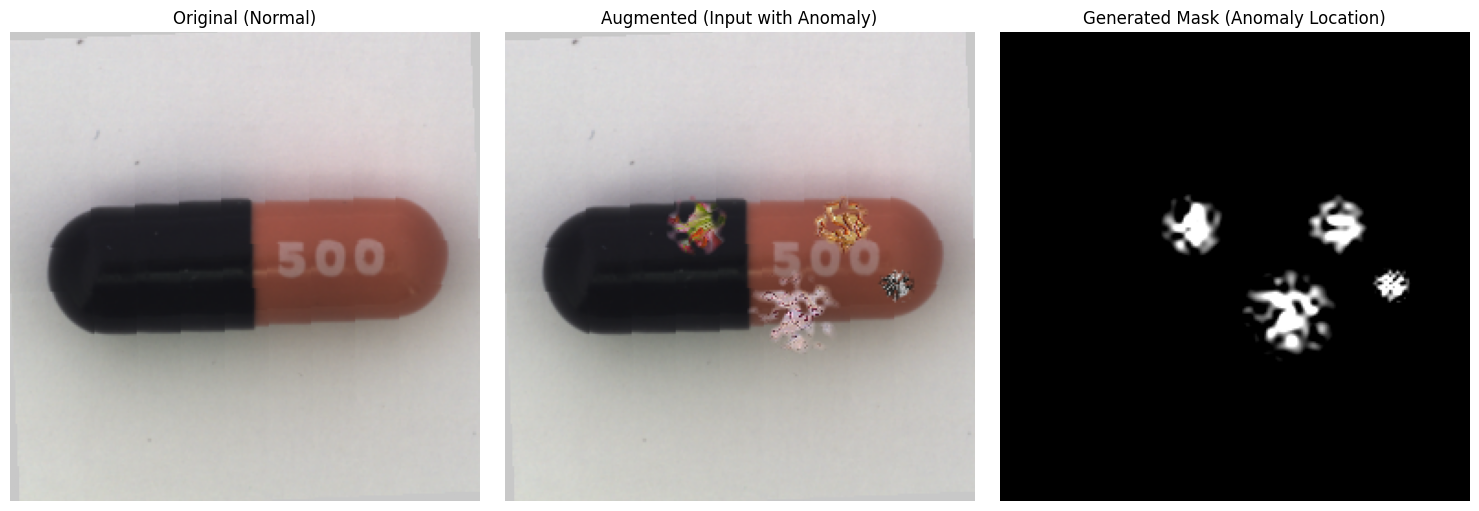

In [ ]:
# 1. Initialize DTD once (Global or passed to Dataset)
dtd = datasets.DTD(root='./data', split='train', download=True)

# 2. Initialize Augmentor
augmentor = AnomalyAugmentor(dtd_dataset=dtd, image_size=(256, 256))

# 3. Simulate getting a "Capsule" image from your Dataloader
# (Assuming your MVTec loader returns a tensor)
rand_num = random.randint(0, len(train_data)-1);
dummy_capsule = train_data[rand_num]

# 4. Generate the Training Data Pair
input_corrupted, mask_target = augmentor.augment(dummy_capsule)

print("Augmentation Successful.")
print(f"Input for Model: {input_corrupted.shape}") # Feed this to Encoder
print(f"Mask for Loss:   {mask_target.shape}")     # Use this for Loss calculation

# 3. Generate Augmentation
corrupted, mask = augmentor.augment(dummy_capsule)

# 4. Visualize
print("Displaying augmentation result...")
visualize_augmentation(dummy_capsule, corrupted, mask.squeeze())

## Loss

In [ ]:
class SelfSupervisedLoss(nn.Module):
    def __init__(self, lambda_factor=0.8):
        # lambda_factor corresponds to 'lambda' in the paper
        # Paper suggests high lambda (e.g., 0.8 or higher) to prioritize the repair task
        super(SelfSupervisedLoss, self).__init__()
        self.lambda_factor = lambda_factor

    def forward(self, reconstruction, original, mask):
        """
        Args:
            reconstruction: Output from the Autoencoder [B, 3, H, W]
            original: The clean, uncorrupted image [B, 3, H, W]
            mask: The binary anomaly mask [B, 1, H, W] (1 = Anomaly, 0 = Normal)
        """
        # 1. Calculate Squared Error per pixel: || f(x_tilde) - x ||^2
        error_map = torch.pow(reconstruction - original, 2)

        # 2. Define Masks
        # mask is M (Anomaly regions)
        # mask_inv is (1 - M) or \bar{M} (Normal regions)
        mask_inv = 1.0 - mask

        # 3. Calculate Normal Loss (Term 1)
        # 1/||M_bar|| * || M_bar * (Reconstruction - Original) ||^2
        # We sum the error map where mask is 0, then divide by the number of normal pixels
        term_normal = (error_map * mask_inv).sum() / (mask_inv.sum() + 1e-6)

        # 4. Calculate Anomaly Loss (Term 2)
        # 1/||M|| * || M * (Reconstruction - Original) ||^2
        # We sum the error map where mask is 1, then divide by the number of anomaly pixels
        term_anomaly = (error_map * mask).sum() / (mask.sum() + 1e-6)

        # 5. Combine with Lambda weights (Equation 1 correction)
        # Loss = (1 - lambda) * Term_Normal + lambda * Term_Anomaly
        total_loss = ((1.0 - self.lambda_factor) * term_normal) + \
                     (self.lambda_factor * term_anomaly)

        return total_loss, term_normal, term_anomaly

## Training with accumulation function

In [ ]:
def train_autoencoder_with_accumulation(model, optimizer, train_loader, val_loader, augmentor, criterion,
                                        epochs=20, accumulation_steps=8, device="cuda", save_best_path=None,
                                        scheduler=None): # <--- Added scheduler argument

    # History dictionaries to track all components
    history = {
        "train_loss": [], "train_norm": [], "train_anom": [],
        "val_loss": [], "val_norm": [], "val_anom": []
    }

    best_val_loss = float("inf")

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()

        # Accumulators for the epoch
        running_loss = 0.0
        running_norm = 0.0
        running_anom = 0.0

        optimizer.zero_grad()

        # Progress bar for training
        loop = tqdm(train_loader, leave=True)

        for i, clean_batch in enumerate(loop):
            # 1. Augmentation (On the Fly)
            clean_batch = clean_batch.to(device)

            corrupted_list = []
            mask_list = []

            # Augment each image in the batch individually
            with torch.no_grad():
                for img in clean_batch:
                    c_img, m = augmentor.augment(img.cpu())
                    corrupted_list.append(c_img)
                    mask_list.append(m)

            # Stack and move to GPU
            inputs_corrupted = torch.stack(corrupted_list).to(device)
            masks = torch.stack(mask_list).to(device)

            # 2. Forward Pass
            outputs = model(inputs_corrupted)

            # 3. Calculate Loss
            loss, loss_norm, loss_anom = criterion(outputs, clean_batch, masks)

            # 4. Normalize loss for accumulation
            loss_scaled = loss / accumulation_steps

            # 5. Backward
            loss_scaled.backward()

            # 6. Optimizer Step (Accumulated)
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            # 7. Logging
            batch_size = clean_batch.size(0)
            running_loss += loss.item() * batch_size
            running_norm += loss_norm.item() * batch_size
            running_anom += loss_anom.item() * batch_size

            # Update Progress Bar
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(total=loss.item(), norm=loss_norm.item(), anom=loss_anom.item())

        # Calculate Epoch Averages
        dataset_size = len(train_loader.dataset)
        epoch_loss = running_loss / dataset_size
        epoch_norm = running_norm / dataset_size
        epoch_anom = running_anom / dataset_size

        history["train_loss"].append(epoch_loss)
        history["train_norm"].append(epoch_norm)
        history["train_anom"].append(epoch_anom)

        # -------- VALIDATION ----------
        model.eval()
        val_running_loss = 0.0
        val_running_norm = 0.0
        val_running_anom = 0.0

        with torch.no_grad():
            for clean_batch in val_loader:
                clean_batch = clean_batch.to(device)

                # Apply same augmentation to Validation to track "Restoration" capability
                val_corr_list = []
                val_mask_list = []
                for img in clean_batch:
                    c_img, m = augmentor.augment(img.cpu())
                    val_corr_list.append(c_img)
                    val_mask_list.append(m)

                inputs_corr_val = torch.stack(val_corr_list).to(device)
                masks_val = torch.stack(val_mask_list).to(device)

                outputs = model(inputs_corr_val)
                v_loss, v_norm, v_anom = criterion(outputs, clean_batch, masks_val)

                bs = clean_batch.size(0)
                val_running_loss += v_loss.item() * bs
                val_running_norm += v_norm.item() * bs
                val_running_anom += v_anom.item() * bs

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_norm = val_running_norm / len(val_loader.dataset)
        val_epoch_anom = val_running_anom / len(val_loader.dataset)

        history["val_loss"].append(val_epoch_loss)
        history["val_norm"].append(val_epoch_norm)
        history["val_anom"].append(val_epoch_anom)

        print(f"\nSummary Ep:{epoch+1} | Train Loss: {epoch_loss:.5f} (Norm:{epoch_norm:.5f} Anom:{epoch_anom:.5f})")
        print(f"               | Val Loss:   {val_epoch_loss:.5f} (Norm:{val_epoch_norm:.5f} Anom:{val_epoch_anom:.5f})")

        # -------- SCHEDULER STEP ----------
        # This checks if the validation loss has plateaued and adjusts LR accordingly
        if scheduler is not None:
            # Check if scheduler is ReduceLROnPlateau (requires metric) or other (StepLR/Cosine)
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_epoch_loss)
            else:
                scheduler.step()

            # Print current learning rate for verification
            current_lr = optimizer.param_groups[0]['lr']
            print(f"--> Current LR: {current_lr:.6f}")

        # Save Best Model based on Total Loss
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            if save_best_path:
                torch.save(model.state_dict(), save_best_path)
                print(f"--> Best model saved at {save_best_path}")

    return history

## Train execution

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
#LOSS, MODEL AND OPTIMIZER, RUNNING TRAINING

model=AutoEncoder().to(device)

#where to store the best model
model_name = "new_config" # @param {"type":"string","placeholder":"configf1"}
best_model_path=extract_path+model_name+".pth"

# 1. Setup
# HYPERPARAMETER SETUP FOR RUN 1
EFFECTIVE_BATCH_SIZE = 32 # @param {"type":"slider","min":1,"max":100,"step":1}
ACCUMULATION_STEPS = EFFECTIVE_BATCH_SIZE // batch_size # Automatically calculates 4 or 8
LEARNING_RATE = 1e-4 # @param {"type":"number","placeholder":"0.0001"}
W_DECAY = 1e-5 # @param {"type":"number","placeholder":"1e-5"}
EPOCHS = 150 # @param {"type":"slider","min":10,"max":1000,"step":10}
LAMBDA = 0.8 # @param {"type":"number","placeholder":"0.8"}

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=W_DECAY)

criterion = SelfSupervisedLoss(lambda_factor=LAMBDA).to(device)
augmentor = AnomalyAugmentor(dtd_dataset=dtd, image_size=(256, 256))

# 2. Define Scheduler (Reduces LR by factor of 0.1 if loss doesn't improve for 3 epochs)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',      # We want to minimize loss
    factor=0.5,      # Reduce LR by this factor
    patience=10      # Number of epochs to wait with no improvement
)

# 3. Run
history = train_autoencoder_with_accumulation(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    augmentor=augmentor,      # New Argument
    criterion=criterion,      # New Argument
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    device=device,
    save_best_path=best_model_path,
    scheduler=scheduler
)

Epoch [1/150]: 100%|██████████| 52/52 [01:48<00:00,  2.09s/it, anom=0.00576, norm=0.0192, total=0.00844]



Summary Ep:1 | Train Loss: 0.01146 (Norm:0.02032 Anom:0.00924)
               | Val Loss:   0.00753 (Norm:0.01932 Anom:0.00458)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [2/150]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00519, norm=0.0219, total=0.00853]



Summary Ep:2 | Train Loss: 0.00796 (Norm:0.01876 Anom:0.00526)
               | Val Loss:   0.00632 (Norm:0.02047 Anom:0.00278)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [3/150]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00372, norm=0.0153, total=0.00604]



Summary Ep:3 | Train Loss: 0.00674 (Norm:0.01730 Anom:0.00411)
               | Val Loss:   0.00671 (Norm:0.01862 Anom:0.00373)
--> Current LR: 0.000100


Epoch [4/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.00318, norm=0.0136, total=0.00527]



Summary Ep:4 | Train Loss: 0.00593 (Norm:0.01628 Anom:0.00334)
               | Val Loss:   0.00663 (Norm:0.01713 Anom:0.00400)
--> Current LR: 0.000100


Epoch [5/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00333, norm=0.0225, total=0.00717]



Summary Ep:5 | Train Loss: 0.00542 (Norm:0.01516 Anom:0.00299)
               | Val Loss:   0.00565 (Norm:0.01665 Anom:0.00290)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [6/150]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00215, norm=0.0104, total=0.0038]



Summary Ep:6 | Train Loss: 0.00521 (Norm:0.01420 Anom:0.00296)
               | Val Loss:   0.00405 (Norm:0.01473 Anom:0.00138)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [7/150]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00218, norm=0.0114, total=0.00402]



Summary Ep:7 | Train Loss: 0.00472 (Norm:0.01328 Anom:0.00258)
               | Val Loss:   0.00603 (Norm:0.01440 Anom:0.00394)
--> Current LR: 0.000100


Epoch [8/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.003, norm=0.0105, total=0.00451]



Summary Ep:8 | Train Loss: 0.00431 (Norm:0.01243 Anom:0.00228)
               | Val Loss:   0.00413 (Norm:0.01320 Anom:0.00186)
--> Current LR: 0.000100


Epoch [9/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.00272, norm=0.0171, total=0.00561]



Summary Ep:9 | Train Loss: 0.00395 (Norm:0.01172 Anom:0.00201)
               | Val Loss:   0.00330 (Norm:0.01178 Anom:0.00119)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [10/150]: 100%|██████████| 52/52 [00:33<00:00,  1.53it/s, anom=0.00363, norm=0.0227, total=0.00745]



Summary Ep:10 | Train Loss: 0.00390 (Norm:0.01097 Anom:0.00213)
               | Val Loss:   0.00379 (Norm:0.01090 Anom:0.00201)
--> Current LR: 0.000100


Epoch [11/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.00211, norm=0.00942, total=0.00357]



Summary Ep:11 | Train Loss: 0.00375 (Norm:0.01032 Anom:0.00211)
               | Val Loss:   0.00436 (Norm:0.01003 Anom:0.00294)
--> Current LR: 0.000100


Epoch [12/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00127, norm=0.0075, total=0.00251]



Summary Ep:12 | Train Loss: 0.00376 (Norm:0.00970 Anom:0.00228)
               | Val Loss:   0.00327 (Norm:0.00860 Anom:0.00193)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [13/150]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00121, norm=0.00804, total=0.00257]



Summary Ep:13 | Train Loss: 0.00400 (Norm:0.00911 Anom:0.00272)
               | Val Loss:   0.00339 (Norm:0.00794 Anom:0.00225)
--> Current LR: 0.000100


Epoch [14/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00173, norm=0.00426, total=0.00224]



Summary Ep:14 | Train Loss: 0.00392 (Norm:0.00861 Anom:0.00275)
               | Val Loss:   0.00339 (Norm:0.00786 Anom:0.00227)
--> Current LR: 0.000100


Epoch [15/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00165, norm=0.00761, total=0.00284]



Summary Ep:15 | Train Loss: 0.00336 (Norm:0.00808 Anom:0.00218)
               | Val Loss:   0.00289 (Norm:0.00789 Anom:0.00164)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [16/150]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.0011, norm=0.0116, total=0.0032]



Summary Ep:16 | Train Loss: 0.00306 (Norm:0.00758 Anom:0.00193)
               | Val Loss:   0.00245 (Norm:0.00805 Anom:0.00105)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [17/150]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.000972, norm=0.00469, total=0.00171]



Summary Ep:17 | Train Loss: 0.00299 (Norm:0.00704 Anom:0.00198)
               | Val Loss:   0.00249 (Norm:0.00682 Anom:0.00141)
--> Current LR: 0.000100


Epoch [18/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.00168, norm=0.00554, total=0.00245]



Summary Ep:18 | Train Loss: 0.00279 (Norm:0.00670 Anom:0.00181)
               | Val Loss:   0.00263 (Norm:0.00683 Anom:0.00158)
--> Current LR: 0.000100


Epoch [19/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.000888, norm=0.00635, total=0.00198]



Summary Ep:19 | Train Loss: 0.00278 (Norm:0.00639 Anom:0.00188)
               | Val Loss:   0.00229 (Norm:0.00661 Anom:0.00121)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [20/150]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00292, norm=0.0071, total=0.00375]



Summary Ep:20 | Train Loss: 0.00269 (Norm:0.00600 Anom:0.00187)
               | Val Loss:   0.00232 (Norm:0.00622 Anom:0.00134)
--> Current LR: 0.000100


Epoch [21/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00153, norm=0.00377, total=0.00198]



Summary Ep:21 | Train Loss: 0.00260 (Norm:0.00557 Anom:0.00186)
               | Val Loss:   0.00221 (Norm:0.00597 Anom:0.00127)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [22/150]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00115, norm=0.00427, total=0.00177]



Summary Ep:22 | Train Loss: 0.00256 (Norm:0.00531 Anom:0.00187)
               | Val Loss:   0.00201 (Norm:0.00493 Anom:0.00128)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [23/150]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.0014, norm=0.00308, total=0.00174]



Summary Ep:23 | Train Loss: 0.00236 (Norm:0.00507 Anom:0.00168)
               | Val Loss:   0.00166 (Norm:0.00466 Anom:0.00091)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [24/150]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00133, norm=0.00409, total=0.00188]



Summary Ep:24 | Train Loss: 0.00225 (Norm:0.00473 Anom:0.00163)
               | Val Loss:   0.00208 (Norm:0.00501 Anom:0.00135)
--> Current LR: 0.000100


Epoch [25/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.000929, norm=0.00374, total=0.00149]



Summary Ep:25 | Train Loss: 0.00230 (Norm:0.00453 Anom:0.00175)
               | Val Loss:   0.00174 (Norm:0.00363 Anom:0.00127)
--> Current LR: 0.000100


Epoch [26/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00494, norm=0.00135, total=0.00422]



Summary Ep:26 | Train Loss: 0.00226 (Norm:0.00421 Anom:0.00178)
               | Val Loss:   0.00216 (Norm:0.00370 Anom:0.00178)
--> Current LR: 0.000100


Epoch [27/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00102, norm=0.00337, total=0.00149]



Summary Ep:27 | Train Loss: 0.00215 (Norm:0.00396 Anom:0.00170)
               | Val Loss:   0.00260 (Norm:0.00440 Anom:0.00215)
--> Current LR: 0.000100


Epoch [28/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.00211, norm=0.00215, total=0.00212]



Summary Ep:28 | Train Loss: 0.00213 (Norm:0.00380 Anom:0.00171)
               | Val Loss:   0.00169 (Norm:0.00362 Anom:0.00120)
--> Current LR: 0.000100


Epoch [29/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00196, norm=0.0053, total=0.00263]



Summary Ep:29 | Train Loss: 0.00199 (Norm:0.00371 Anom:0.00156)
               | Val Loss:   0.00162 (Norm:0.00341 Anom:0.00117)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [30/150]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00169, norm=0.00236, total=0.00183]



Summary Ep:30 | Train Loss: 0.00184 (Norm:0.00340 Anom:0.00145)
               | Val Loss:   0.00154 (Norm:0.00411 Anom:0.00089)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [31/150]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.000804, norm=0.00355, total=0.00135]



Summary Ep:31 | Train Loss: 0.00215 (Norm:0.00325 Anom:0.00188)
               | Val Loss:   0.00220 (Norm:0.00307 Anom:0.00199)
--> Current LR: 0.000100


Epoch [32/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00311, norm=0.00393, total=0.00327]



Summary Ep:32 | Train Loss: 0.00206 (Norm:0.00313 Anom:0.00179)
               | Val Loss:   0.00190 (Norm:0.00354 Anom:0.00149)
--> Current LR: 0.000100


Epoch [33/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.00109, norm=0.00215, total=0.0013]



Summary Ep:33 | Train Loss: 0.00174 (Norm:0.00293 Anom:0.00145)
               | Val Loss:   0.00177 (Norm:0.00339 Anom:0.00136)
--> Current LR: 0.000100


Epoch [34/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00206, norm=0.00226, total=0.0021]



Summary Ep:34 | Train Loss: 0.00191 (Norm:0.00277 Anom:0.00170)
               | Val Loss:   0.00125 (Norm:0.00266 Anom:0.00090)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [35/150]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.000869, norm=0.004, total=0.0015]



Summary Ep:35 | Train Loss: 0.00177 (Norm:0.00265 Anom:0.00154)
               | Val Loss:   0.00138 (Norm:0.00270 Anom:0.00105)
--> Current LR: 0.000100


Epoch [36/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00105, norm=0.00316, total=0.00147]



Summary Ep:36 | Train Loss: 0.00166 (Norm:0.00252 Anom:0.00145)
               | Val Loss:   0.00130 (Norm:0.00273 Anom:0.00094)
--> Current LR: 0.000100


Epoch [37/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.00106, norm=0.00157, total=0.00117]



Summary Ep:37 | Train Loss: 0.00162 (Norm:0.00245 Anom:0.00141)
               | Val Loss:   0.00165 (Norm:0.00260 Anom:0.00142)
--> Current LR: 0.000100


Epoch [38/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000763, norm=0.00158, total=0.000926]



Summary Ep:38 | Train Loss: 0.00163 (Norm:0.00235 Anom:0.00145)
               | Val Loss:   0.00125 (Norm:0.00251 Anom:0.00093)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [39/150]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.000907, norm=0.00559, total=0.00184]



Summary Ep:39 | Train Loss: 0.00165 (Norm:0.00227 Anom:0.00150)
               | Val Loss:   0.00151 (Norm:0.00237 Anom:0.00129)
--> Current LR: 0.000100


Epoch [40/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00168, norm=0.00218, total=0.00178]



Summary Ep:40 | Train Loss: 0.00156 (Norm:0.00215 Anom:0.00141)
               | Val Loss:   0.00114 (Norm:0.00242 Anom:0.00082)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [41/150]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00212, norm=0.00107, total=0.00191]



Summary Ep:41 | Train Loss: 0.00155 (Norm:0.00205 Anom:0.00142)
               | Val Loss:   0.00145 (Norm:0.00196 Anom:0.00132)
--> Current LR: 0.000100


Epoch [42/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.00172, norm=0.00146, total=0.00166]



Summary Ep:42 | Train Loss: 0.00162 (Norm:0.00195 Anom:0.00154)
               | Val Loss:   0.00129 (Norm:0.00240 Anom:0.00102)
--> Current LR: 0.000100


Epoch [43/150]: 100%|██████████| 52/52 [00:32<00:00,  1.59it/s, anom=0.0018, norm=0.00083, total=0.00161]



Summary Ep:43 | Train Loss: 0.00164 (Norm:0.00193 Anom:0.00157)
               | Val Loss:   0.00175 (Norm:0.00234 Anom:0.00161)
--> Current LR: 0.000100


Epoch [44/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.00144, norm=0.000859, total=0.00132]



Summary Ep:44 | Train Loss: 0.00160 (Norm:0.00186 Anom:0.00154)
               | Val Loss:   0.00113 (Norm:0.00122 Anom:0.00111)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [45/150]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.000761, norm=0.00121, total=0.000851]



Summary Ep:45 | Train Loss: 0.00134 (Norm:0.00169 Anom:0.00125)
               | Val Loss:   0.00131 (Norm:0.00139 Anom:0.00130)
--> Current LR: 0.000100


Epoch [46/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00196, norm=0.000837, total=0.00174]



Summary Ep:46 | Train Loss: 0.00148 (Norm:0.00163 Anom:0.00144)
               | Val Loss:   0.00130 (Norm:0.00152 Anom:0.00124)
--> Current LR: 0.000100


Epoch [47/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.00205, norm=0.00187, total=0.00201]



Summary Ep:47 | Train Loss: 0.00133 (Norm:0.00155 Anom:0.00127)
               | Val Loss:   0.00110 (Norm:0.00123 Anom:0.00107)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [48/150]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.0016, norm=0.00237, total=0.00176]



Summary Ep:48 | Train Loss: 0.00135 (Norm:0.00153 Anom:0.00131)
               | Val Loss:   0.00096 (Norm:0.00158 Anom:0.00080)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [49/150]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00158, norm=0.000839, total=0.00143]



Summary Ep:49 | Train Loss: 0.00122 (Norm:0.00150 Anom:0.00115)
               | Val Loss:   0.00084 (Norm:0.00106 Anom:0.00079)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [50/150]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.000467, norm=0.000984, total=0.00057]



Summary Ep:50 | Train Loss: 0.00125 (Norm:0.00145 Anom:0.00120)
               | Val Loss:   0.00132 (Norm:0.00112 Anom:0.00137)
--> Current LR: 0.000100


Epoch [51/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.0011, norm=0.00082, total=0.00104]



Summary Ep:51 | Train Loss: 0.00137 (Norm:0.00144 Anom:0.00135)
               | Val Loss:   0.00113 (Norm:0.00136 Anom:0.00107)
--> Current LR: 0.000100


Epoch [52/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00152, norm=0.000731, total=0.00136]



Summary Ep:52 | Train Loss: 0.00125 (Norm:0.00139 Anom:0.00121)
               | Val Loss:   0.00116 (Norm:0.00124 Anom:0.00115)
--> Current LR: 0.000100


Epoch [53/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.00137, norm=0.000908, total=0.00128]



Summary Ep:53 | Train Loss: 0.00148 (Norm:0.00138 Anom:0.00151)
               | Val Loss:   0.00092 (Norm:0.00093 Anom:0.00092)
--> Current LR: 0.000100


Epoch [54/150]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.000383, norm=0.000943, total=0.000495]



Summary Ep:54 | Train Loss: 0.00136 (Norm:0.00132 Anom:0.00137)
               | Val Loss:   0.00136 (Norm:0.00081 Anom:0.00149)
--> Current LR: 0.000100


Epoch [55/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000552, norm=0.000582, total=0.000558]



Summary Ep:55 | Train Loss: 0.00140 (Norm:0.00128 Anom:0.00144)
               | Val Loss:   0.00103 (Norm:0.00074 Anom:0.00110)
--> Current LR: 0.000100


Epoch [56/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.00179, norm=0.00351, total=0.00213]



Summary Ep:56 | Train Loss: 0.00149 (Norm:0.00119 Anom:0.00157)
               | Val Loss:   0.00102 (Norm:0.00078 Anom:0.00107)
--> Current LR: 0.000100


Epoch [57/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00165, norm=0.000538, total=0.00143]



Summary Ep:57 | Train Loss: 0.00133 (Norm:0.00110 Anom:0.00138)
               | Val Loss:   0.00118 (Norm:0.00101 Anom:0.00122)
--> Current LR: 0.000100


Epoch [58/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.00223, norm=0.000714, total=0.00193]



Summary Ep:58 | Train Loss: 0.00154 (Norm:0.00117 Anom:0.00163)
               | Val Loss:   0.00087 (Norm:0.00077 Anom:0.00089)
--> Current LR: 0.000100


Epoch [59/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00124, norm=0.00127, total=0.00125]



Summary Ep:59 | Train Loss: 0.00136 (Norm:0.00114 Anom:0.00141)
               | Val Loss:   0.00103 (Norm:0.00089 Anom:0.00106)
--> Current LR: 0.000100


Epoch [60/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00146, norm=0.000554, total=0.00128]



Summary Ep:60 | Train Loss: 0.00144 (Norm:0.00112 Anom:0.00152)
               | Val Loss:   0.00147 (Norm:0.00079 Anom:0.00164)
--> Current LR: 0.000050


Epoch [61/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000662, norm=0.00095, total=0.000719]



Summary Ep:61 | Train Loss: 0.00126 (Norm:0.00101 Anom:0.00133)
               | Val Loss:   0.00127 (Norm:0.00086 Anom:0.00137)
--> Current LR: 0.000050


Epoch [62/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.000692, norm=0.00138, total=0.000829]



Summary Ep:62 | Train Loss: 0.00115 (Norm:0.00105 Anom:0.00118)
               | Val Loss:   0.00076 (Norm:0.00089 Anom:0.00072)
--> Current LR: 0.000050
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [63/150]: 100%|██████████| 52/52 [00:33<00:00,  1.53it/s, anom=0.00158, norm=0.00205, total=0.00168]



Summary Ep:63 | Train Loss: 0.00106 (Norm:0.00101 Anom:0.00107)
               | Val Loss:   0.00061 (Norm:0.00073 Anom:0.00058)
--> Current LR: 0.000050
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [64/150]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00123, norm=0.0012, total=0.00122]



Summary Ep:64 | Train Loss: 0.00111 (Norm:0.00097 Anom:0.00115)
               | Val Loss:   0.00090 (Norm:0.00091 Anom:0.00090)
--> Current LR: 0.000050


Epoch [65/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.00166, norm=0.000576, total=0.00144]



Summary Ep:65 | Train Loss: 0.00107 (Norm:0.00100 Anom:0.00109)
               | Val Loss:   0.00070 (Norm:0.00062 Anom:0.00073)
--> Current LR: 0.000050


Epoch [66/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.000636, norm=0.000755, total=0.00066]



Summary Ep:66 | Train Loss: 0.00106 (Norm:0.00094 Anom:0.00110)
               | Val Loss:   0.00071 (Norm:0.00073 Anom:0.00070)
--> Current LR: 0.000050


Epoch [67/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00165, norm=0.00064, total=0.00145]



Summary Ep:67 | Train Loss: 0.00107 (Norm:0.00091 Anom:0.00111)
               | Val Loss:   0.00085 (Norm:0.00074 Anom:0.00088)
--> Current LR: 0.000050


Epoch [68/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00103, norm=0.00133, total=0.00109]



Summary Ep:68 | Train Loss: 0.00112 (Norm:0.00102 Anom:0.00115)
               | Val Loss:   0.00063 (Norm:0.00078 Anom:0.00060)
--> Current LR: 0.000050


Epoch [69/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.000858, norm=0.00059, total=0.000804]



Summary Ep:69 | Train Loss: 0.00108 (Norm:0.00093 Anom:0.00112)
               | Val Loss:   0.00074 (Norm:0.00061 Anom:0.00078)
--> Current LR: 0.000050


Epoch [70/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.000738, norm=0.000701, total=0.000731]



Summary Ep:70 | Train Loss: 0.00113 (Norm:0.00092 Anom:0.00119)
               | Val Loss:   0.00065 (Norm:0.00070 Anom:0.00064)
--> Current LR: 0.000050


Epoch [71/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00114, norm=0.00419, total=0.00175]



Summary Ep:71 | Train Loss: 0.00100 (Norm:0.00091 Anom:0.00102)
               | Val Loss:   0.00048 (Norm:0.00077 Anom:0.00041)
--> Current LR: 0.000050
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [72/150]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00105, norm=0.0005, total=0.000939]



Summary Ep:72 | Train Loss: 0.00103 (Norm:0.00094 Anom:0.00105)
               | Val Loss:   0.00075 (Norm:0.00063 Anom:0.00078)
--> Current LR: 0.000050


Epoch [73/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.000854, norm=0.00141, total=0.000965]



Summary Ep:73 | Train Loss: 0.00107 (Norm:0.00094 Anom:0.00110)
               | Val Loss:   0.00095 (Norm:0.00076 Anom:0.00099)
--> Current LR: 0.000050


Epoch [74/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000836, norm=0.000615, total=0.000792]



Summary Ep:74 | Train Loss: 0.00107 (Norm:0.00093 Anom:0.00110)
               | Val Loss:   0.00069 (Norm:0.00082 Anom:0.00066)
--> Current LR: 0.000050


Epoch [75/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.000624, norm=0.000658, total=0.00063]



Summary Ep:75 | Train Loss: 0.00101 (Norm:0.00095 Anom:0.00103)
               | Val Loss:   0.00073 (Norm:0.00077 Anom:0.00072)
--> Current LR: 0.000050


Epoch [76/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.000568, norm=0.000591, total=0.000572]



Summary Ep:76 | Train Loss: 0.00095 (Norm:0.00096 Anom:0.00095)
               | Val Loss:   0.00081 (Norm:0.00077 Anom:0.00082)
--> Current LR: 0.000050


Epoch [77/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000714, norm=0.000616, total=0.000694]



Summary Ep:77 | Train Loss: 0.00105 (Norm:0.00085 Anom:0.00110)
               | Val Loss:   0.00076 (Norm:0.00054 Anom:0.00082)
--> Current LR: 0.000050


Epoch [78/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00059, norm=0.000916, total=0.000655]



Summary Ep:78 | Train Loss: 0.00101 (Norm:0.00088 Anom:0.00104)
               | Val Loss:   0.00058 (Norm:0.00077 Anom:0.00053)
--> Current LR: 0.000050


Epoch [79/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00111, norm=0.000678, total=0.00103]



Summary Ep:79 | Train Loss: 0.00114 (Norm:0.00087 Anom:0.00121)
               | Val Loss:   0.00082 (Norm:0.00076 Anom:0.00084)
--> Current LR: 0.000050


Epoch [80/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00147, norm=0.000499, total=0.00128]



Summary Ep:80 | Train Loss: 0.00105 (Norm:0.00086 Anom:0.00110)
               | Val Loss:   0.00084 (Norm:0.00056 Anom:0.00091)
--> Current LR: 0.000050


Epoch [81/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.000717, norm=0.000483, total=0.00067]



Summary Ep:81 | Train Loss: 0.00105 (Norm:0.00085 Anom:0.00110)
               | Val Loss:   0.00067 (Norm:0.00057 Anom:0.00069)
--> Current LR: 0.000050


Epoch [82/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000647, norm=0.00249, total=0.00102]



Summary Ep:82 | Train Loss: 0.00103 (Norm:0.00083 Anom:0.00109)
               | Val Loss:   0.00065 (Norm:0.00078 Anom:0.00062)
--> Current LR: 0.000025


Epoch [83/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00103, norm=0.000483, total=0.000922]



Summary Ep:83 | Train Loss: 0.00092 (Norm:0.00080 Anom:0.00094)
               | Val Loss:   0.00052 (Norm:0.00055 Anom:0.00051)
--> Current LR: 0.000025


Epoch [84/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.00143, norm=0.000502, total=0.00124]



Summary Ep:84 | Train Loss: 0.00093 (Norm:0.00085 Anom:0.00095)
               | Val Loss:   0.00061 (Norm:0.00047 Anom:0.00064)
--> Current LR: 0.000025


Epoch [85/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.00152, norm=0.0018, total=0.00158]



Summary Ep:85 | Train Loss: 0.00096 (Norm:0.00078 Anom:0.00101)
               | Val Loss:   0.00081 (Norm:0.00067 Anom:0.00084)
--> Current LR: 0.000025


Epoch [86/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.0011, norm=0.00194, total=0.00127]



Summary Ep:86 | Train Loss: 0.00089 (Norm:0.00080 Anom:0.00092)
               | Val Loss:   0.00066 (Norm:0.00058 Anom:0.00068)
--> Current LR: 0.000025


Epoch [87/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000946, norm=0.000565, total=0.00087]



Summary Ep:87 | Train Loss: 0.00098 (Norm:0.00089 Anom:0.00100)
               | Val Loss:   0.00053 (Norm:0.00056 Anom:0.00052)
--> Current LR: 0.000025


Epoch [88/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.000768, norm=0.000561, total=0.000726]



Summary Ep:88 | Train Loss: 0.00085 (Norm:0.00079 Anom:0.00087)
               | Val Loss:   0.00075 (Norm:0.00057 Anom:0.00080)
--> Current LR: 0.000025


Epoch [89/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.00183, norm=0.000803, total=0.00162]



Summary Ep:89 | Train Loss: 0.00098 (Norm:0.00080 Anom:0.00102)
               | Val Loss:   0.00050 (Norm:0.00047 Anom:0.00051)
--> Current LR: 0.000025


Epoch [90/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000688, norm=0.000494, total=0.000649]



Summary Ep:90 | Train Loss: 0.00085 (Norm:0.00081 Anom:0.00087)
               | Val Loss:   0.00052 (Norm:0.00059 Anom:0.00051)
--> Current LR: 0.000025


Epoch [91/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00132, norm=0.000416, total=0.00114]



Summary Ep:91 | Train Loss: 0.00092 (Norm:0.00077 Anom:0.00096)
               | Val Loss:   0.00067 (Norm:0.00051 Anom:0.00071)
--> Current LR: 0.000025


Epoch [92/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.000694, norm=0.000509, total=0.000657]



Summary Ep:92 | Train Loss: 0.00085 (Norm:0.00075 Anom:0.00087)
               | Val Loss:   0.00065 (Norm:0.00060 Anom:0.00067)
--> Current LR: 0.000025


Epoch [93/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.000817, norm=0.00227, total=0.00111]



Summary Ep:93 | Train Loss: 0.00087 (Norm:0.00079 Anom:0.00088)
               | Val Loss:   0.00053 (Norm:0.00058 Anom:0.00052)
--> Current LR: 0.000013


Epoch [94/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.000423, norm=0.00048, total=0.000435]



Summary Ep:94 | Train Loss: 0.00082 (Norm:0.00078 Anom:0.00083)
               | Val Loss:   0.00100 (Norm:0.00047 Anom:0.00114)
--> Current LR: 0.000013


Epoch [95/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000569, norm=0.000731, total=0.000602]



Summary Ep:95 | Train Loss: 0.00092 (Norm:0.00081 Anom:0.00095)
               | Val Loss:   0.00069 (Norm:0.00048 Anom:0.00074)
--> Current LR: 0.000013


Epoch [96/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000714, norm=0.000462, total=0.000663]



Summary Ep:96 | Train Loss: 0.00087 (Norm:0.00076 Anom:0.00090)
               | Val Loss:   0.00039 (Norm:0.00056 Anom:0.00035)
--> Current LR: 0.000013
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [97/150]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.000465, norm=0.000377, total=0.000448]



Summary Ep:97 | Train Loss: 0.00084 (Norm:0.00076 Anom:0.00086)
               | Val Loss:   0.00056 (Norm:0.00046 Anom:0.00059)
--> Current LR: 0.000013


Epoch [98/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00089, norm=0.000564, total=0.000825]



Summary Ep:98 | Train Loss: 0.00083 (Norm:0.00076 Anom:0.00084)
               | Val Loss:   0.00069 (Norm:0.00053 Anom:0.00073)
--> Current LR: 0.000013


Epoch [99/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.000516, norm=0.000486, total=0.00051]



Summary Ep:99 | Train Loss: 0.00088 (Norm:0.00083 Anom:0.00089)
               | Val Loss:   0.00074 (Norm:0.00049 Anom:0.00080)
--> Current LR: 0.000013


Epoch [100/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00185, norm=0.000725, total=0.00163]



Summary Ep:100 | Train Loss: 0.00078 (Norm:0.00075 Anom:0.00079)
               | Val Loss:   0.00064 (Norm:0.00053 Anom:0.00067)
--> Current LR: 0.000013


Epoch [101/150]: 100%|██████████| 52/52 [00:33<00:00,  1.58it/s, anom=0.000719, norm=0.000457, total=0.000666]



Summary Ep:101 | Train Loss: 0.00074 (Norm:0.00078 Anom:0.00072)
               | Val Loss:   0.00094 (Norm:0.00053 Anom:0.00104)
--> Current LR: 0.000013


Epoch [102/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.000509, norm=0.000445, total=0.000497]



Summary Ep:102 | Train Loss: 0.00091 (Norm:0.00083 Anom:0.00093)
               | Val Loss:   0.00058 (Norm:0.00050 Anom:0.00060)
--> Current LR: 0.000013


Epoch [103/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.000598, norm=0.000497, total=0.000577]



Summary Ep:103 | Train Loss: 0.00085 (Norm:0.00075 Anom:0.00088)
               | Val Loss:   0.00053 (Norm:0.00045 Anom:0.00055)
--> Current LR: 0.000013


Epoch [104/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.0005, norm=0.00078, total=0.000556]



Summary Ep:104 | Train Loss: 0.00077 (Norm:0.00078 Anom:0.00077)
               | Val Loss:   0.00110 (Norm:0.00047 Anom:0.00126)
--> Current LR: 0.000013


Epoch [105/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.000812, norm=0.000482, total=0.000746]



Summary Ep:105 | Train Loss: 0.00085 (Norm:0.00074 Anom:0.00087)
               | Val Loss:   0.00051 (Norm:0.00058 Anom:0.00049)
--> Current LR: 0.000013


Epoch [106/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000522, norm=0.00205, total=0.000828]



Summary Ep:106 | Train Loss: 0.00083 (Norm:0.00071 Anom:0.00086)
               | Val Loss:   0.00086 (Norm:0.00057 Anom:0.00094)
--> Current LR: 0.000013


Epoch [107/150]: 100%|██████████| 52/52 [00:33<00:00,  1.58it/s, anom=0.00155, norm=0.00206, total=0.00165]



Summary Ep:107 | Train Loss: 0.00084 (Norm:0.00073 Anom:0.00087)
               | Val Loss:   0.00076 (Norm:0.00059 Anom:0.00080)
--> Current LR: 0.000006


Epoch [108/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.000851, norm=0.000459, total=0.000773]



Summary Ep:108 | Train Loss: 0.00079 (Norm:0.00074 Anom:0.00080)
               | Val Loss:   0.00088 (Norm:0.00044 Anom:0.00100)
--> Current LR: 0.000006


Epoch [109/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.00126, norm=0.00111, total=0.00123]



Summary Ep:109 | Train Loss: 0.00087 (Norm:0.00081 Anom:0.00088)
               | Val Loss:   0.00055 (Norm:0.00041 Anom:0.00059)
--> Current LR: 0.000006


Epoch [110/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.00109, norm=0.000415, total=0.000956]



Summary Ep:110 | Train Loss: 0.00080 (Norm:0.00077 Anom:0.00081)
               | Val Loss:   0.00059 (Norm:0.00052 Anom:0.00060)
--> Current LR: 0.000006


Epoch [111/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.000321, norm=0.000489, total=0.000354]



Summary Ep:111 | Train Loss: 0.00081 (Norm:0.00078 Anom:0.00082)
               | Val Loss:   0.00035 (Norm:0.00050 Anom:0.00031)
--> Current LR: 0.000006
--> Best model saved at /content/drive/MyDrive/Project/E-Code/confige5.pth


Epoch [112/150]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.000305, norm=0.000677, total=0.000379]



Summary Ep:112 | Train Loss: 0.00080 (Norm:0.00077 Anom:0.00080)
               | Val Loss:   0.00097 (Norm:0.00052 Anom:0.00108)
--> Current LR: 0.000006


Epoch [113/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.000619, norm=0.000471, total=0.00059]



Summary Ep:113 | Train Loss: 0.00085 (Norm:0.00079 Anom:0.00086)
               | Val Loss:   0.00039 (Norm:0.00048 Anom:0.00037)
--> Current LR: 0.000006


Epoch [114/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.000459, norm=0.000463, total=0.00046]



Summary Ep:114 | Train Loss: 0.00080 (Norm:0.00069 Anom:0.00083)
               | Val Loss:   0.00076 (Norm:0.00048 Anom:0.00083)
--> Current LR: 0.000006


Epoch [115/150]: 100%|██████████| 52/52 [00:32<00:00,  1.58it/s, anom=0.000711, norm=0.000456, total=0.00066]



Summary Ep:115 | Train Loss: 0.00078 (Norm:0.00070 Anom:0.00081)
               | Val Loss:   0.00035 (Norm:0.00048 Anom:0.00032)
--> Current LR: 0.000006


Epoch [116/150]: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s, anom=0.00038, norm=0.000475, total=0.000399]



Summary Ep:116 | Train Loss: 0.00075 (Norm:0.00073 Anom:0.00075)
               | Val Loss:   0.00046 (Norm:0.00051 Anom:0.00045)
--> Current LR: 0.000006


Epoch [117/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000908, norm=0.00107, total=0.000941]



Summary Ep:117 | Train Loss: 0.00080 (Norm:0.00074 Anom:0.00082)
               | Val Loss:   0.00074 (Norm:0.00061 Anom:0.00077)
--> Current LR: 0.000006


Epoch [118/150]: 100%|██████████| 52/52 [00:33<00:00,  1.57it/s, anom=0.000648, norm=0.000385, total=0.000595]



Summary Ep:118 | Train Loss: 0.00078 (Norm:0.00071 Anom:0.00080)
               | Val Loss:   0.00048 (Norm:0.00042 Anom:0.00049)
--> Current LR: 0.000006


Epoch [119/150]: 100%|██████████| 52/52 [00:33<00:00,  1.56it/s, anom=0.000612, norm=0.000411, total=0.000572]



Summary Ep:119 | Train Loss: 0.00075 (Norm:0.00071 Anom:0.00077)
               | Val Loss:   0.00052 (Norm:0.00047 Anom:0.00053)
--> Current LR: 0.000006


Epoch [120/150]:  46%|████▌     | 24/52 [00:15<00:17,  1.61it/s, anom=0.000531, norm=0.000456, total=0.000516]

## Loss curves

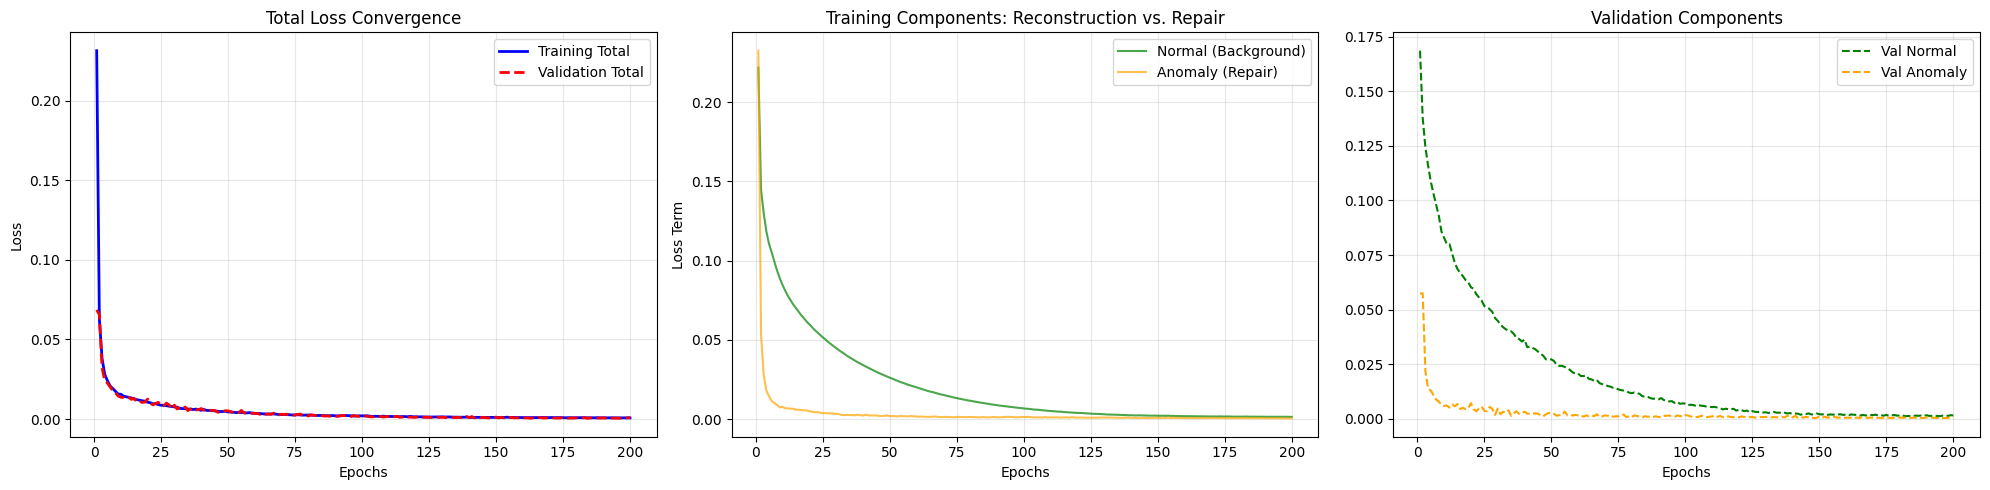

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Create a figure with 3 subplots side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # --- Plot 1: Total Loss (Train vs Val) ---
    # This tells you if the model is overfitting
    axes[0].plot(epochs, history['train_loss'], label='Training Total', color='blue', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Validation Total', color='red', linestyle='--', linewidth=2)
    axes[0].set_title('Total Loss Convergence')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # --- Plot 2: Training Components (Normal vs Anomaly) ---
    # This tells you if the model is focusing on the 'Repair' task
    axes[1].plot(epochs, history['train_norm'], label='Normal (Background)', color='green', alpha=0.7)
    axes[1].plot(epochs, history['train_anom'], label='Anomaly (Repair)', color='orange', alpha=0.7)
    axes[1].set_title('Training Components: Reconstruction vs. Repair')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss Term')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    # Use log scale if anomaly loss is much larger than normal loss initially
    # axes[1].set_yscale('log')

    # --- Plot 3: Validation Components ---
    # This tells you if the repair capability generalizes to unseen data
    axes[2].plot(epochs, history['val_norm'], label='Val Normal', color='green', linestyle='--')
    axes[2].plot(epochs, history['val_anom'], label='Val Anomaly', color='orange', linestyle='--')
    axes[2].set_title('Validation Components')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- Example Usage ---
# Assuming 'history' is the dictionary returned by train_autoencoder_with_accumulation
plot_training_history(history)

# Testing (Phase 1) 🏃

## Model selection

In [ ]:
# Test model
test_model = AutoEncoder().to(device)

# Define the path to your saved state_dict
model_path = extract_path+"confige5.pth"

# --- Steps to load a model when only the state_dict was saved ---

# 1. Load the state_dict
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# 3. Load the state_dict into your instantiated model
test_model.load_state_dict(state_dict)

# 4. Set the model to evaluation mode
test_model.eval()

print("Model state_dict loading setup complete. Remember to instantiate your model and uncomment the loading lines.")

Model state_dict loading setup complete. Remember to instantiate your model and uncomment the loading lines.


## Anomaly maps

In [ ]:
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a 1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    """
    def __init__(self, channels, kernel_size=15, sigma=4.0, dim=2):
        super(GaussianSmoothing, self).__init__()

        # 1. Create The Gaussian Kernel Vector
        if isinstance(kernel_size, int):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, float):
            sigma = [sigma] * dim

        # The meshgrids for the kernel
        kernel = 1
        meshgrids = torch.meshgrid(
            [torch.arange(size, dtype=torch.float32) for size in kernel_size],
            indexing='ij' # Standard indexing
        )

        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) ** 2) / (2 * std ** 2))

        # Normalize so sum = 1 (to maintain brightness)
        kernel = kernel / torch.sum(kernel)

        # 2. Reshape to PyTorch Weights
        # Shape: [Out_Channels, In_Channels/Groups, H, W]
        # Depthwise Conv: Out=Channels, In=1, Groups=Channels
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        # 3. Create the Convolution Layer (Fixed, not learnable)
        self.register_buffer('weight', kernel)
        self.groups = channels
        self.conv = F.conv2d

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        # Padding = kernel_size // 2 to maintain image size
        padding = self.weight.shape[-1] // 2
        return self.conv(input, weight=self.weight, groups=self.groups, padding=padding)

def compute_anomaly_map(image_tensor, model, smoothing_layer, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)

        # 1. Forward Pass
        reconstruction = model(image_tensor)

        # 2. Squared Difference
        diff = torch.pow(image_tensor - reconstruction, 2)

        # 3. Mean across channels
        anomaly_map = torch.mean(diff, dim=1, keepdim=True)

        # 4. Apply Gaussian Smoothing
        anomaly_map_smooth = smoothing_layer(anomaly_map)

        # 5. --- FIX: NORMALIZE TO 0-1 RANGE ---
        # We normalize per image so the anomaly becomes the brightest point (1.0)
        am_min = anomaly_map_smooth.min()
        am_max = anomaly_map_smooth.max()

        # Avoid division by zero if image is perfectly reconstructed (max == min)
        if am_max - am_min > 1e-8:
            anomaly_map_smooth = (anomaly_map_smooth - am_min) / (am_max - am_min)

        # Return as [H, W] numpy
        return anomaly_map_smooth.squeeze().cpu().numpy(), reconstruction

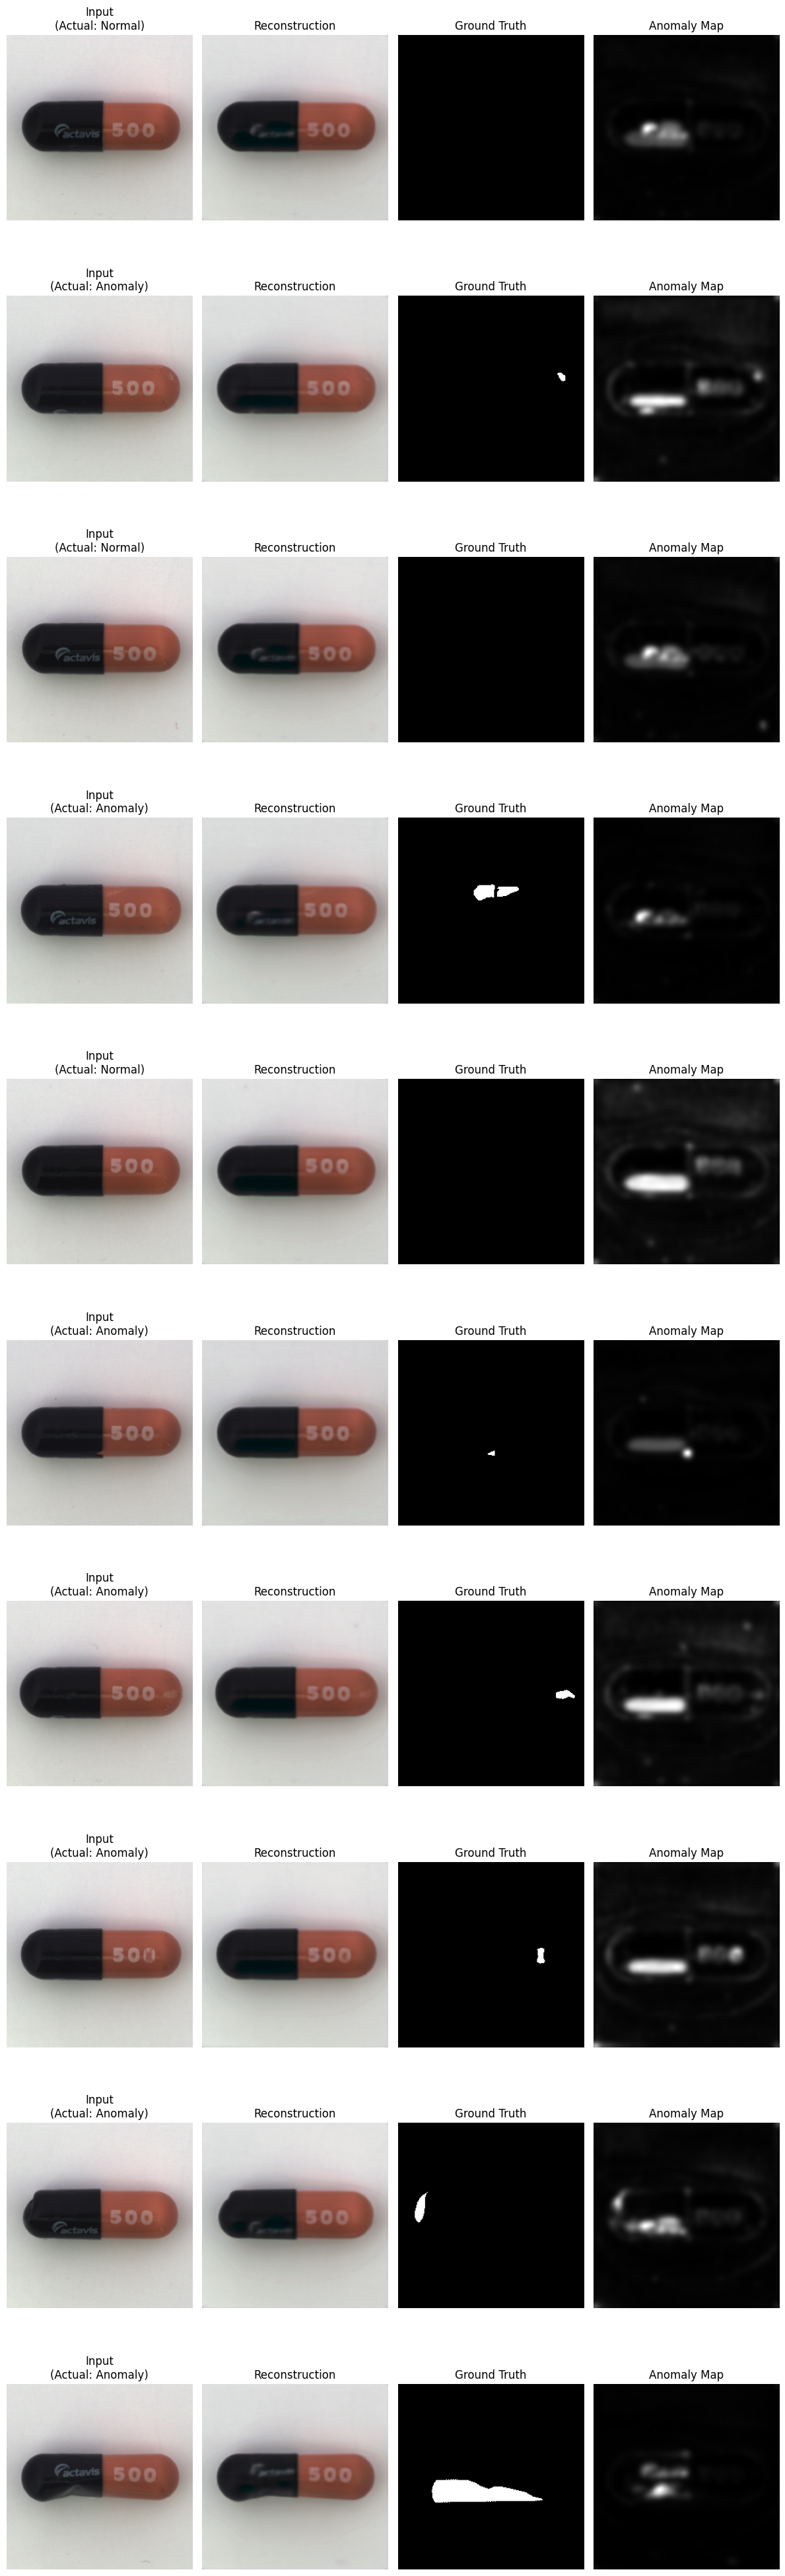

In [ ]:
def get_matching_gt_path(img_path, gt_root_dir):
    """
    Intelligently finds the matching ground truth mask by preserving the
    defect category structure (e.g., 'scratch', 'crack').
    """
    # 1. Identify the defect category from the image path
    # Example: .../test/scratch/000.png -> parent is "scratch"
    defect_type = os.path.basename(os.path.dirname(img_path))

    # 2. Identify the filename
    filename = os.path.basename(img_path)
    name, ext = os.path.splitext(filename)

    # 3. Construct the corresponding GT path
    # We look for: gt_root_dir / scratch / 000_mask.png
    mask_filename = f"{name}_mask{ext}"

    # Join paths carefully
    possible_path = os.path.join(gt_root_dir, defect_type, mask_filename)

    return possible_path

def visualize_anomaly_maps(model, test_loader, gt_root_dir, smoother, device="cuda", num_images=4):
    """
    Visualizes results with:
    1. Randomly selected images (both normal and anomalous if available).
    2. Correct subfolder matching for Ground Truth.
    3. Paper-style Grayscale Heatmaps.
    """

    # --- 1. COLLECT DATA ---
    all_samples = []
    for images, labels, paths in test_loader:
        for i in range(len(images)):
            all_samples.append({
                'tensor': images[i],
                'path': paths[i],
                'label': labels[i].item() # Store the label
            })

    normal_samples = [s for s in all_samples if s['label'] == 0]
    anomaly_samples = [s for s in all_samples if s['label'] == 1]

    selected_samples = []

    # Shuffle lists to allow easy popping without ambiguous comparisons
    random.shuffle(normal_samples)
    random.shuffle(anomaly_samples)

    # Try to include at least one normal and one anomalous sample if possible
    if len(normal_samples) > 0:
        selected_samples.append(normal_samples.pop()) # Pop from shuffled list

    if len(anomaly_samples) > 0 and len(selected_samples) < num_images:
        selected_samples.append(anomaly_samples.pop()) # Pop from shuffled list

    # Combine remaining samples and shuffle
    remaining_samples = normal_samples + anomaly_samples
    random.shuffle(remaining_samples)

    # Fill up the rest of the num_images with random remaining samples
    while len(selected_samples) < num_images and len(remaining_samples) > 0:
        selected_samples.append(remaining_samples.pop(0))

    num_images_to_plot = len(selected_samples)
    if num_images_to_plot == 0:
        print("No samples to plot.")
        return

    # --- 2. PROCESS & PLOT ---
    # Create a figure with 'num_images_to_plot' rows
    plt.figure(figsize=(12, 4 * num_images_to_plot))

    for i, sample in enumerate(selected_samples): # Iterate over selected_samples
        img_tensor = sample['tensor'].unsqueeze(0) # Add batch dim [1, 3, H, W]
        img_path = sample['path']
        actual_label = sample['label'] # Get actual label

        # A. Find Ground Truth Mask
        gt_mask = np.zeros((img_tensor.shape[2], img_tensor.shape[3]), dtype=np.float32) # Default to all zeros
        if actual_label == 1: # Only try to load GT mask for anomalous samples
            gt_mask_path = get_matching_gt_path(img_path, gt_root_dir)
            if os.path.exists(gt_mask_path):
                loaded_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)

                if loaded_mask is not None:
                    h, w = img_tensor.shape[2], img_tensor.shape[3]
                    # Resize to match image size
                    loaded_mask = cv2.resize(loaded_mask, (w, h), interpolation=cv2.INTER_NEAREST)
                    gt_mask = loaded_mask.astype(np.float32) / 255.0
                # else: print(f"Warning: Failed to load mask from {gt_mask_path}. Assuming no GT mask.")
            # else: print(f"Warning: GT mask not found at {gt_mask_path} for anomalous image.")

        # B. Run Inference
        heatmap, recon_tensor = compute_anomaly_map(img_tensor, model, smoother, device)

        # C. Prepare Visuals
        input_img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
        recon_img = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

        # --- D. PLOTTING ---
        row = i
        cols = 4

        # Column 1: Input
        plt.subplot(num_images_to_plot, cols, row * cols + 1)
        plt.imshow(np.clip(input_img, 0, 1))
        plt.title(f"Input\n(Actual: {'Normal' if actual_label == 0 else 'Anomaly'})") # Update title with label
        plt.axis('off')

        # Column 2: Reconstruction
        plt.subplot(num_images_to_plot, cols, row * cols + 2)
        plt.imshow(np.clip(recon_img, 0, 1))
        plt.title("Reconstruction")
        plt.axis('off')

        # Column 3: Ground Truth (Gray)
        plt.subplot(num_images_to_plot, cols, row * cols + 3)
        plt.imshow(gt_mask, cmap='gray', vmin=0, vmax=1)
        plt.title("Ground Truth")
        plt.axis('off')

        # Column 4: Predicted Heatmap (Gray - Paper Style)
        plt.subplot(num_images_to_plot, cols, row * cols + 4)
        plt.imshow(heatmap, cmap='gray', vmin=0, vmax=1)
        plt.title("Anomaly Map")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


gaussian_smoother = GaussianSmoothing(channels=1, kernel_size=21, sigma=4.0).to(device)

visualize_anomaly_maps(
     model=test_model,
     test_loader=test_loader,
     gt_root_dir=extract_path+"capsule/capsule/ground_truth", # Root GT folder
     smoother=gaussian_smoother,
     device=device,
     num_images=10  # Change this to see more rows
 )

## Pixel-wise AUC-ROC

In [ ]:
def evaluate_pixel_wise_auc(model, test_loader, gt_root_dir, smoother, device="cuda"):
    """
    Calculates the Pixel-wise AUC-ROC score with robust file handling.
    """
    model.eval()

    all_gt_pixels = []
    all_pred_pixels = []

    print("Starting Pixel-wise AUC evaluation...")

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images, labels, paths = batch
            images = images.to(device)

            # --- 1. Run Model ---
            reconstruction = model(images)

            # --- 2. Calculate Anomaly Map ---
            diff = torch.pow(images - reconstruction, 2)
            anomaly_map = torch.mean(diff, dim=1, keepdim=True)
            anomaly_map = smoother(anomaly_map)

            pred_maps = anomaly_map.squeeze(1).cpu().numpy()

            # --- 3. Process each image ---
            for i in range(len(images)):
                img_path = paths[i]

                # A. Load Ground Truth Mask
                gt_path = get_matching_gt_path(img_path, gt_root_dir)

                # Default to a "Clean" mask (all zeros)
                mask = np.zeros_like(pred_maps[i], dtype=int)

                if os.path.exists(gt_path):
                    loaded_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

                    # --- SAFETY CHECK: Ensure mask loaded correctly ---
                    if loaded_mask is not None:
                        h, w = pred_maps[i].shape
                        # Resize to match model output
                        loaded_mask = cv2.resize(loaded_mask, (w, h), interpolation=cv2.INTER_NEAREST)
                        mask = (loaded_mask > 128).astype(int)
                    else:
                        # Optional: Print warning if file exists but fails to load
                        # print(f"Warning: Failed to load mask at {gt_path}. Assuming clean.")
                        pass

                # B. Flatten and Store
                all_gt_pixels.append(mask.flatten())
                all_pred_pixels.append(pred_maps[i].flatten())

    # --- 4. Concatenate & Score ---
    y_true = np.concatenate(all_gt_pixels)
    y_score = np.concatenate(all_pred_pixels)

    print("Calculating ROC Score...")
    pixel_auc = roc_auc_score(y_true, y_score)

    return pixel_auc, y_true, y_score

Starting Pixel-wise AUC evaluation...


Evaluating: 100%|██████████| 132/132 [00:15<00:00,  8.59it/s]


Calculating ROC Score...

Result: Pixel-wise AUC-ROC: 0.8451


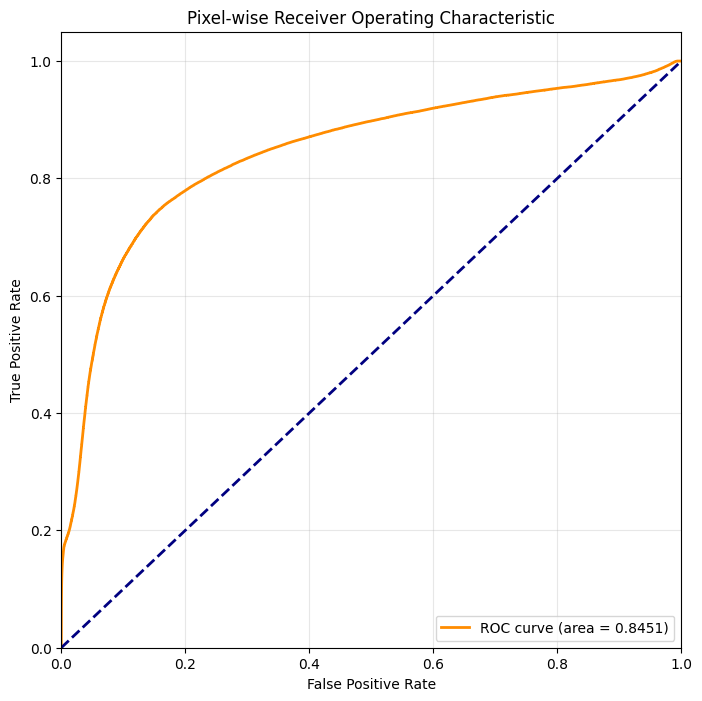

In [ ]:
# 1. Run Evaluation
# Ensure 'paper_smoother' is the one you initialized earlier
auc_score, y_true, y_score = evaluate_pixel_wise_auc(
    model=test_model,
    test_loader=test_loader,
    gt_root_dir=extract_path+"capsule/capsule/ground_truth", # Adjust path
    smoother=gaussian_smoother,
    device=device
)

print(f"\nResult: Pixel-wise AUC-ROC: {auc_score:.4f}")

# 2. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pixel-wise Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## Image-level AUC ROC

In [ ]:
def evaluate_image_level_auc(model, test_loader, smoother, device="cuda"):
    """
    Calculates the Image-level AUC-ROC score.
    Assigns a single score to each image based on the max value of its anomaly map.
    """
    model.eval()

    # Store image-level labels and scores
    image_labels = []
    image_scores = []

    print("Starting Image-level AUC evaluation...")

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating Images"):
            # Unpack batch
            # We assume labels are: 0 = Good/Normal, 1 = Anomaly
            images, labels, paths = batch

            images = images.to(device)

            # 1. Forward Pass
            reconstruction = model(images)

            # 2. Calculate Anomaly Map
            # Squared Error
            diff = torch.pow(images - reconstruction, 2)

            # Mean across channels
            anomaly_map = torch.mean(diff, dim=1, keepdim=True)

            # Apply Smoothing (Important: reduces noise spikes)
            anomaly_map = smoother(anomaly_map)

            # 3. Calculate Image Score
            # Strategy: The score of the image is the MAXIMUM error found in it.
            # Shape: [Batch_Size, 1, H, W] -> [Batch_Size]
            # Flatten to [Batch, H*W] then take max per row
            batch_size = images.shape[0]
            flat_maps = anomaly_map.view(batch_size, -1)
            batch_scores = torch.max(flat_maps, dim=1)[0] # [0] gets values, [1] gets indices

            # 4. Store
            image_labels.extend(labels.numpy())
            image_scores.extend(batch_scores.cpu().numpy())

    # --- Calculate Metric ---
    image_labels = np.array(image_labels)
    image_scores = np.array(image_scores)

    # Safety Check: Ensure we have both classes (Normal and Anomaly)
    if len(np.unique(image_labels)) < 2:
        print("Warning: Only one class detected in test set. AUC cannot be calculated.")
        return 0.0, image_labels, image_scores

    auc_score = roc_auc_score(image_labels, image_scores)

    return auc_score, image_labels, image_scores

In [ ]:
def plot_image_roc_curve(y_true, y_score, auc_score,title):
    """
    Plots the ROC Curve for image-level detection.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Image ROC (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

Starting Image-level AUC evaluation...


Evaluating Images: 100%|██████████| 132/132 [00:13<00:00,  9.98it/s]



Image-level AUC: 0.7016


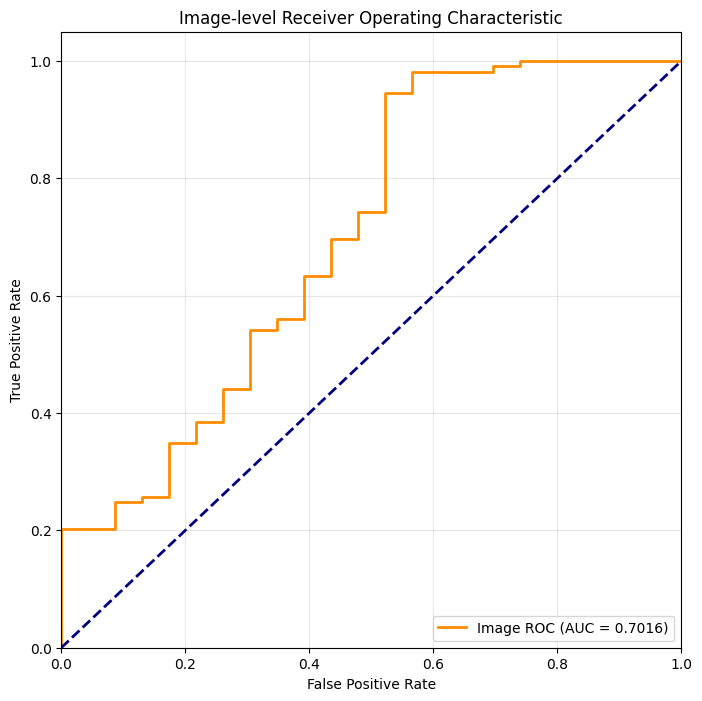

In [ ]:
# 1. Run Evaluation
img_auc, img_labels, img_scores = evaluate_image_level_auc(
    model=test_model,
    test_loader=test_loader,
    smoother=gaussian_smoother, # Use the same smoother as pixel-wise
    device=device
)

print(f"\nImage-level AUC: {img_auc:.4f}")

# 2. Plot
plot_image_roc_curve(img_labels, img_scores, img_auc,"Image-level Receiver Operating Characteristic")

## Decision threshold

In [ ]:
def find_threshold_statistical_paper(model, normal_val_loader, smoother, device="cuda", k=3.0):
    """
    Calculates threshold using the statistical method (Mean + k*Std) based on
    the Anomaly Map scores (not the training loss).

    Args:
        model: Trained Autoencoder
        normal_val_loader: DataLoader containing ONLY 'Good' images.
                           (Usually a split of the training set or the 'good' test folder)
        smoother: The GaussianSmoothing layer used in inference.
        k (float): Strictness. Higher k = Fewer False Positives (Normal classified as Anomaly).
                   Standard values: 2.0 to 4.0.
    """
    model.eval()
    model.to(device)

    normal_max_scores = []

    print(f"Calculating statistical threshold using k={k}...")

    with torch.no_grad():
        for batch in normal_val_loader:
            # Handle different loader outputs (Images, Labels, Paths) vs (Images, Labels)
            if len(batch) == 3:
                images, _, _ = batch
            elif len(batch) == 2:
                images, _ = batch
            else:
                images = batch

            images = images.to(device)

            # --- 1. The Paper's Inference Steps ---

            # Reconstruction
            reconstruction = model(images)

            # Squared Difference Map
            diff = torch.pow(images - reconstruction, 2)

            # Mean across channels
            anomaly_map = torch.mean(diff, dim=1, keepdim=True)

            # Gaussian Smoothing (Crucial for consistent scoring)
            anomaly_map = smoother(anomaly_map)

            # --- 2. Extract Score ---
            # The score of an image is the MAX value in its heatmap
            # Shape: [Batch, 1, H, W] -> flatten -> max
            batch_scores = anomaly_map.view(images.size(0), -1).max(dim=1).values

            normal_max_scores.extend(batch_scores.cpu().numpy())

    # --- 3. Calculate Statistics ---
    scores = np.array(normal_max_scores)
    mu = np.mean(scores)
    sigma = np.std(scores)

    # Threshold definition
    threshold = mu + (k * sigma)

    print(f"Stats -> Mean: {mu:.6f} | Std: {sigma:.6f}")
    print(f"Calculated Threshold: {threshold:.6f}")

    # --- 4. Visualization (Optional but Recommended) ---
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=50, alpha=0.7, color='green', label='Normal Scores')
    plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (k={k})')
    plt.title("Distribution of Anomaly Scores (Normal Data)")
    plt.xlabel("Max Anomaly Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    return threshold

# Domain Shift (Phase 2) ⚡

## Shifted dataset

In [ ]:
#adding sensor-noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        # Ensure noise is only added to the image range
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0, 1) # Clamp to keep pixel values in valid range [0, 1]

### Train dataset

In [ ]:
#data augmentations I for the training-set
"""
some variation in lightning conditions and added sensor-noise
"""
image_train_transforms_shifted_I = transforms.Compose([
    transforms.Resize((size, size)),

    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.15,
            contrast=0.15,
            hue=0.05
        )
    ],p=0.5),

    transforms.ToTensor(),

    transforms.RandomApply([
        AddGaussianNoise(mean=0., std=0.01)
    ], p=0.5)
])

#data augmentations II for training-set
"""
some variation in resolution (downscale upto 80% before upscaling to original size), lightning-conditions and added sensor-noise
"""

image_train_transforms_shifted_II = transforms.Compose([
    transforms.Resize((size, size)),

    transforms.RandomApply([
        transforms.Lambda(
            lambda img: transforms.Resize(
                int(size*(0.8 + 0.2*torch.rand(1).item())),
            )(img)
        ),
        transforms.Resize((size, size)) # Upscale back to target size
    ],p=0.5),

    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.15,
            contrast=0.15,
            hue=0.05
        )
    ],p=0.5),

    transforms.ToTensor(),

    transforms.RandomApply([
        AddGaussianNoise(mean=0., std=0.02)
    ], p=0.5)
])

In [ ]:
train_data_shifted=MVTecDataset(train_list, transform=image_train_transforms_shifted_II) #TODO: change function for transformation
val_data_shifted=MVTecDataset(val_list, transform=image_val_transforms)

train_loader_shifted=DataLoader(
    dataset=train_data_shifted,
    batch_size=batch_size,
    shuffle=True
)

val_loader_shifted=DataLoader(
    dataset=val_data,
    batch_size=1,
    shuffle=False #for validation
)

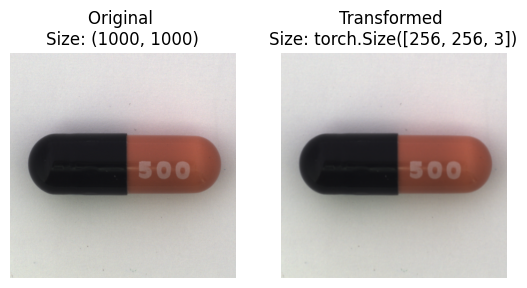

In [ ]:
random_image_path = train_list[2]
image_transformation_plot(random_image_path, image_train_transforms_shifted_I)

### Test dataset

In [ ]:
#Data augmentation for the test-set
image_test_transforms_shifted = transforms.Compose([
    transforms.Resize(int(size*1.3)), # Create a buffer zone for spatial transforms


    transforms.RandomApply([
      transforms.RandomAffine(
          degrees=5, #rotation
          scale=(1, 1.1), # Allow slight zoom-in or no change, prevent zoom-out
          interpolation=transforms.InterpolationMode.BILINEAR,
          fill=200 # Fill exposed areas with mid-gray
      )
    ],p=0.7), #apply zoom-in to 70% of images

    # Simulate resolution changes (downscale and then upscale)
    transforms.RandomApply([
        transforms.Resize(int(size * torch.rand(1).item() * 0.5 + size * 0.5)), # Random resize between 50% and 100% of 'size'
        transforms.Resize((size, size)) # Upscale back to target size
    ], p=0.5), # Apply resolution change with 50% probability

    # Varied lighting settings
    transforms.RandomApply([
      transforms.ColorJitter(
          brightness=0.3,
          contrast=0.3,
          )
    ], p=0.5), # Apply varied lightning-conditions with 50% probability


    transforms.Resize((size, size)), # Final resize to target size
    transforms.ToTensor(),

    # Add Gaussian noise (sensor noise)
    transforms.RandomApply([AddGaussianNoise(mean=0., std=0.03)], p=0.75) # Apply noise with 75% probability
])

In [ ]:
test_data_shifted=MVTecDatasetTest(test_list, transform=image_test_transforms_shifted)

test_loader_shifted=DataLoader(
    dataset=test_data_shifted,
    batch_size=1,
    shuffle=False #for validation
)

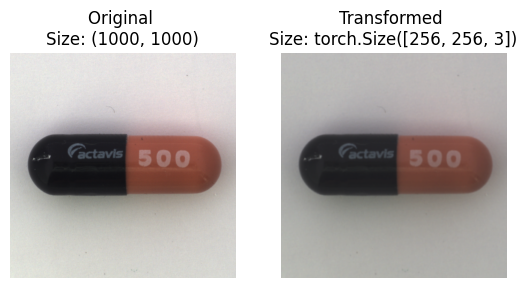

In [ ]:
random_image_path = test_list[2]
image_transformation_plot(random_image_path, image_test_transforms_shifted)

## Test under domain shift

### ROC-AUC image-level

Starting Image-level AUC evaluation...


Evaluating Images: 100%|██████████| 132/132 [07:49<00:00,  3.55s/it]


Image-level AUC: 0.5249


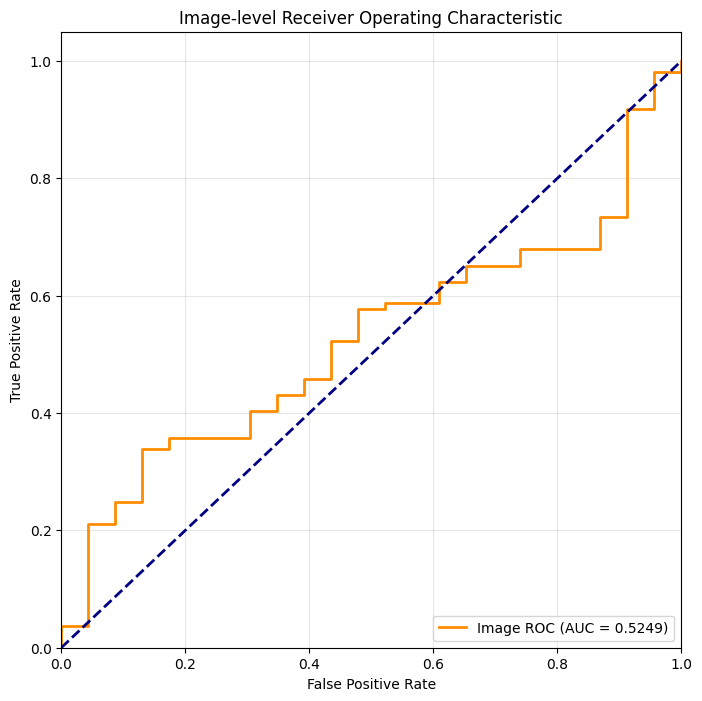

In [ ]:
# 1. Run Evaluation
gaussian_smoother = GaussianSmoothing(channels=1, kernel_size=21, sigma=4.0).to(device)

img_auc, img_labels, img_scores = evaluate_image_level_auc(
    model=test_model,
    test_loader=test_loader_shifted,
    smoother=gaussian_smoother,
    device=device
)

print(f"\nImage-level AUC: {img_auc:.4f}")

# 2. Plot
plot_image_roc_curve(img_labels, img_scores, img_auc,"Image-level Receiver Operating Characteristic")

### Anomaly Maps

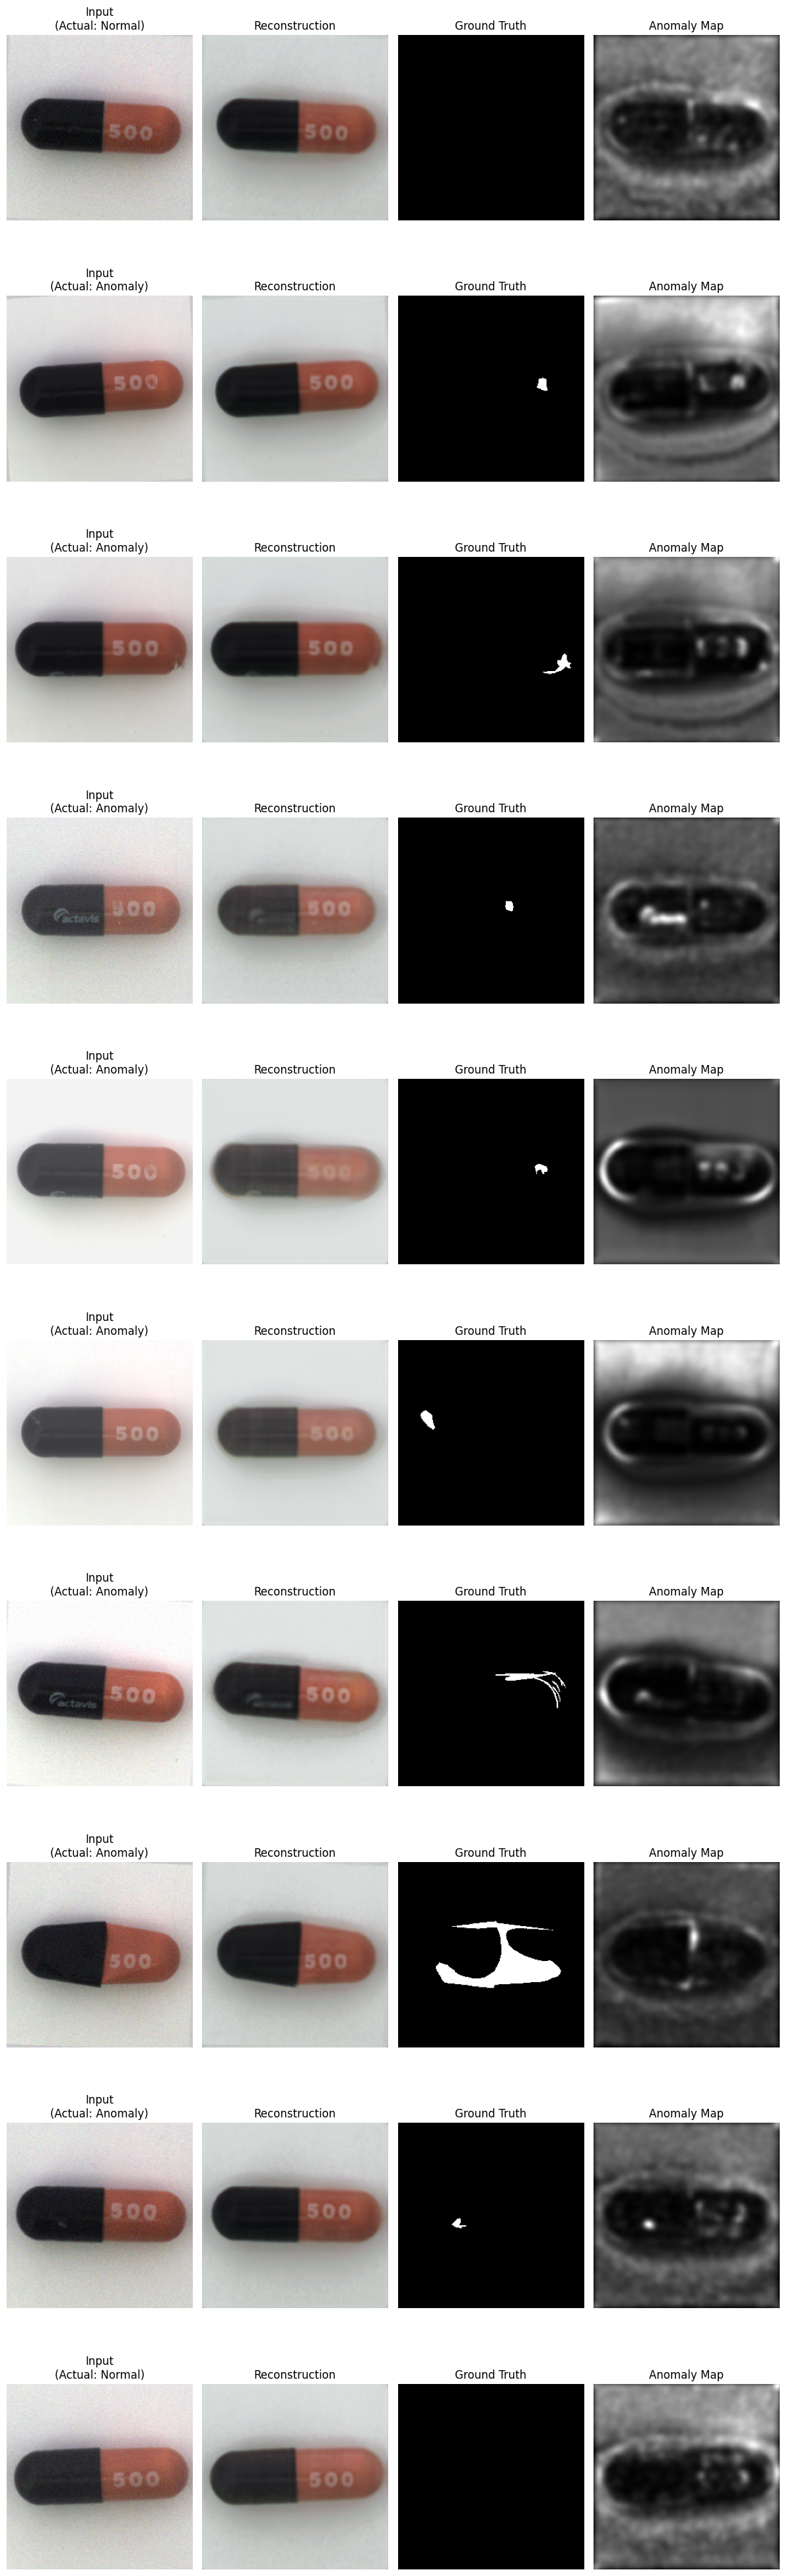

In [ ]:
visualize_anomaly_maps(
     model=test_model,
     test_loader=test_loader_shifted,
     gt_root_dir=extract_path+"capsule/capsule/ground_truth", # Root GT folder
     smoother=gaussian_smoother,
     device=device,
     num_images=10  # Change this to see more rows
 )

## Training with data augmentations

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
#LOSS, MODEL AND OPTIMIZER, RUNNING TRAINING

model=AutoEncoder().to(device)

#where to store the best model
model_name = "sh_config2_ds2" # @param {"type":"string","placeholder":"configf1"}
best_model_path=extract_path+model_name+".pth"

# 1. Setup
# HYPERPARAMETER SETUP FOR RUN 1
EFFECTIVE_BATCH_SIZE = 32 # @param {"type":"slider","min":1,"max":100,"step":1}
ACCUMULATION_STEPS = EFFECTIVE_BATCH_SIZE // batch_size # Automatically calculates 4 or 8
LEARNING_RATE = 1e-4 # @param {"type":"number","placeholder":"0.0001"}
W_DECAY = 1e-5 # @param {"type":"number","placeholder":"1e-5"}
EPOCHS = 200 # @param {"type":"slider","min":10,"max":1000,"step":10}
LAMBDA = 0.9 # @param {"type":"number","placeholder":"0.8"}

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=W_DECAY)

criterion = SelfSupervisedLoss(lambda_factor=LAMBDA).to(device)
augmentor = AnomalyAugmentor(dtd_dataset=dtd, image_size=(256, 256))

# 2. Define Scheduler (Reduces LR by factor of 0.1 if loss doesn't improve for 3 epochs)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',      # We want to minimize loss
    factor=0.5,      # Reduce LR by this factor
    patience=10      # Number of epochs to wait with no improvement
)

# 3. Run
history = train_autoencoder_with_accumulation(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_shifted,
    val_loader=val_loader_shifted,
    augmentor=augmentor,      # New Argument
    criterion=criterion,      # New Argument
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    device=device,
    save_best_path=best_model_path,
    scheduler=scheduler
)

Epoch [1/200]: 100%|██████████| 52/52 [02:13<00:00,  2.57s/it, anom=0.0732, norm=0.138, total=0.0797]



Summary Ep:1 | Train Loss: 0.20746 (Norm:0.24402 Anom:0.20340)
               | Val Loss:   0.09623 (Norm:0.19210 Anom:0.08558)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [2/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.0267, norm=0.121, total=0.0361]



Summary Ep:2 | Train Loss: 0.06104 (Norm:0.16232 Anom:0.04978)
               | Val Loss:   0.05152 (Norm:0.13856 Anom:0.04185)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [3/200]: 100%|██████████| 52/52 [00:36<00:00,  1.41it/s, anom=0.0295, norm=0.184, total=0.0449]



Summary Ep:3 | Train Loss: 0.03991 (Norm:0.14162 Anom:0.02861)
               | Val Loss:   0.03385 (Norm:0.13342 Anom:0.02278)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [4/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.0089, norm=0.115, total=0.0195]



Summary Ep:4 | Train Loss: 0.02690 (Norm:0.12333 Anom:0.01618)
               | Val Loss:   0.02416 (Norm:0.11746 Anom:0.01379)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [5/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.0104, norm=0.0996, total=0.0194]



Summary Ep:5 | Train Loss: 0.02412 (Norm:0.11950 Anom:0.01353)
               | Val Loss:   0.01931 (Norm:0.10552 Anom:0.00973)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [6/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00737, norm=0.138, total=0.0204]



Summary Ep:6 | Train Loss: 0.02125 (Norm:0.10999 Anom:0.01139)
               | Val Loss:   0.01688 (Norm:0.10854 Anom:0.00669)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [7/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00641, norm=0.116, total=0.0174]



Summary Ep:7 | Train Loss: 0.02108 (Norm:0.11056 Anom:0.01114)
               | Val Loss:   0.01840 (Norm:0.10521 Anom:0.00875)
--> Current LR: 0.000100


Epoch [8/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.0166, norm=0.104, total=0.0254]



Summary Ep:8 | Train Loss: 0.01914 (Norm:0.09912 Anom:0.01026)
               | Val Loss:   0.01618 (Norm:0.09627 Anom:0.00728)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [9/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00984, norm=0.0772, total=0.0166]



Summary Ep:9 | Train Loss: 0.01803 (Norm:0.09540 Anom:0.00944)
               | Val Loss:   0.01528 (Norm:0.08863 Anom:0.00713)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [10/200]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, anom=0.0101, norm=0.0884, total=0.0179]



Summary Ep:10 | Train Loss: 0.01708 (Norm:0.08971 Anom:0.00901)
               | Val Loss:   0.01451 (Norm:0.08987 Anom:0.00614)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [11/200]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, anom=0.00554, norm=0.0693, total=0.0119]



Summary Ep:11 | Train Loss: 0.01669 (Norm:0.09221 Anom:0.00830)
               | Val Loss:   0.01692 (Norm:0.08996 Anom:0.00881)
--> Current LR: 0.000100


Epoch [12/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00851, norm=0.085, total=0.0162]



Summary Ep:12 | Train Loss: 0.01665 (Norm:0.08782 Anom:0.00875)
               | Val Loss:   0.01265 (Norm:0.07844 Anom:0.00534)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [13/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.0107, norm=0.0843, total=0.0181]



Summary Ep:13 | Train Loss: 0.01647 (Norm:0.08055 Anom:0.00935)
               | Val Loss:   0.01299 (Norm:0.07580 Anom:0.00601)
--> Current LR: 0.000100


Epoch [14/200]: 100%|██████████| 52/52 [00:34<00:00,  1.53it/s, anom=0.00437, norm=0.0918, total=0.0131]



Summary Ep:14 | Train Loss: 0.01598 (Norm:0.08279 Anom:0.00856)
               | Val Loss:   0.01344 (Norm:0.07768 Anom:0.00630)
--> Current LR: 0.000100


Epoch [15/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00945, norm=0.0721, total=0.0157]



Summary Ep:15 | Train Loss: 0.01479 (Norm:0.07803 Anom:0.00776)
               | Val Loss:   0.01063 (Norm:0.06965 Anom:0.00407)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [16/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.0132, norm=0.0862, total=0.0205]



Summary Ep:16 | Train Loss: 0.01399 (Norm:0.07393 Anom:0.00734)
               | Val Loss:   0.01033 (Norm:0.06714 Anom:0.00402)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [17/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00575, norm=0.0716, total=0.0123]



Summary Ep:17 | Train Loss: 0.01352 (Norm:0.06966 Anom:0.00728)
               | Val Loss:   0.01182 (Norm:0.06733 Anom:0.00565)
--> Current LR: 0.000100


Epoch [18/200]: 100%|██████████| 52/52 [00:33<00:00,  1.53it/s, anom=0.00977, norm=0.0819, total=0.017]



Summary Ep:18 | Train Loss: 0.01356 (Norm:0.06646 Anom:0.00768)
               | Val Loss:   0.01019 (Norm:0.06163 Anom:0.00447)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [19/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00505, norm=0.0874, total=0.0133]



Summary Ep:19 | Train Loss: 0.01249 (Norm:0.06328 Anom:0.00685)
               | Val Loss:   0.01160 (Norm:0.06059 Anom:0.00615)
--> Current LR: 0.000100


Epoch [20/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00432, norm=0.0512, total=0.00901]



Summary Ep:20 | Train Loss: 0.01306 (Norm:0.06243 Anom:0.00758)
               | Val Loss:   0.01116 (Norm:0.05899 Anom:0.00585)
--> Current LR: 0.000100


Epoch [21/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00672, norm=0.0728, total=0.0133]



Summary Ep:21 | Train Loss: 0.01343 (Norm:0.06476 Anom:0.00773)
               | Val Loss:   0.01176 (Norm:0.06385 Anom:0.00597)
--> Current LR: 0.000100


Epoch [22/200]: 100%|██████████| 52/52 [00:35<00:00,  1.49it/s, anom=0.006, norm=0.0264, total=0.00804]



Summary Ep:22 | Train Loss: 0.01246 (Norm:0.06380 Anom:0.00676)
               | Val Loss:   0.01056 (Norm:0.05457 Anom:0.00566)
--> Current LR: 0.000100


Epoch [23/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00821, norm=0.0791, total=0.0153]



Summary Ep:23 | Train Loss: 0.01231 (Norm:0.06136 Anom:0.00686)
               | Val Loss:   0.00965 (Norm:0.05861 Anom:0.00421)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [24/200]: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, anom=0.00741, norm=0.0484, total=0.0115]



Summary Ep:24 | Train Loss: 0.01198 (Norm:0.05824 Anom:0.00684)
               | Val Loss:   0.00962 (Norm:0.05257 Anom:0.00485)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [25/200]: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, anom=0.00499, norm=0.0491, total=0.0094]



Summary Ep:25 | Train Loss: 0.01250 (Norm:0.05829 Anom:0.00741)
               | Val Loss:   0.00843 (Norm:0.04852 Anom:0.00398)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [26/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00489, norm=0.0567, total=0.0101]



Summary Ep:26 | Train Loss: 0.01118 (Norm:0.05410 Anom:0.00641)
               | Val Loss:   0.00916 (Norm:0.04923 Anom:0.00471)
--> Current LR: 0.000100


Epoch [27/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00399, norm=0.0498, total=0.00857]



Summary Ep:27 | Train Loss: 0.01096 (Norm:0.05181 Anom:0.00642)
               | Val Loss:   0.00914 (Norm:0.04886 Anom:0.00472)
--> Current LR: 0.000100


Epoch [28/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00902, norm=0.0219, total=0.0103]



Summary Ep:28 | Train Loss: 0.01013 (Norm:0.04743 Anom:0.00598)
               | Val Loss:   0.00826 (Norm:0.04117 Anom:0.00461)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [29/200]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, anom=0.0068, norm=0.0441, total=0.0105]



Summary Ep:29 | Train Loss: 0.01028 (Norm:0.04945 Anom:0.00592)
               | Val Loss:   0.00726 (Norm:0.04458 Anom:0.00311)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [30/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00786, norm=0.0338, total=0.0105]



Summary Ep:30 | Train Loss: 0.00983 (Norm:0.04787 Anom:0.00561)
               | Val Loss:   0.00741 (Norm:0.04125 Anom:0.00365)
--> Current LR: 0.000100


Epoch [31/200]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00559, norm=0.0438, total=0.00941]



Summary Ep:31 | Train Loss: 0.01094 (Norm:0.05096 Anom:0.00649)
               | Val Loss:   0.00863 (Norm:0.04241 Anom:0.00488)
--> Current LR: 0.000100


Epoch [32/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00368, norm=0.0435, total=0.00766]



Summary Ep:32 | Train Loss: 0.01040 (Norm:0.04745 Anom:0.00628)
               | Val Loss:   0.00728 (Norm:0.03944 Anom:0.00370)
--> Current LR: 0.000100


Epoch [33/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.0101, norm=0.0326, total=0.0123]



Summary Ep:33 | Train Loss: 0.00940 (Norm:0.04061 Anom:0.00593)
               | Val Loss:   0.00649 (Norm:0.03816 Anom:0.00297)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [34/200]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, anom=0.00938, norm=0.0167, total=0.0101]



Summary Ep:34 | Train Loss: 0.00915 (Norm:0.04192 Anom:0.00551)
               | Val Loss:   0.00690 (Norm:0.03542 Anom:0.00373)
--> Current LR: 0.000100


Epoch [35/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00289, norm=0.0405, total=0.00665]



Summary Ep:35 | Train Loss: 0.00934 (Norm:0.04276 Anom:0.00562)
               | Val Loss:   0.00901 (Norm:0.03992 Anom:0.00558)
--> Current LR: 0.000100


Epoch [36/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00437, norm=0.0339, total=0.00732]



Summary Ep:36 | Train Loss: 0.00904 (Norm:0.04048 Anom:0.00555)
               | Val Loss:   0.00721 (Norm:0.03343 Anom:0.00429)
--> Current LR: 0.000100


Epoch [37/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00372, norm=0.0498, total=0.00833]



Summary Ep:37 | Train Loss: 0.00875 (Norm:0.03994 Anom:0.00528)
               | Val Loss:   0.00727 (Norm:0.03496 Anom:0.00419)
--> Current LR: 0.000100


Epoch [38/200]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00604, norm=0.047, total=0.0101]



Summary Ep:38 | Train Loss: 0.00848 (Norm:0.03941 Anom:0.00505)
               | Val Loss:   0.00720 (Norm:0.03713 Anom:0.00388)
--> Current LR: 0.000100


Epoch [39/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00486, norm=0.0622, total=0.0106]



Summary Ep:39 | Train Loss: 0.00872 (Norm:0.03838 Anom:0.00542)
               | Val Loss:   0.00709 (Norm:0.03476 Anom:0.00401)
--> Current LR: 0.000100


Epoch [40/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00387, norm=0.0239, total=0.00588]



Summary Ep:40 | Train Loss: 0.00848 (Norm:0.03900 Anom:0.00508)
               | Val Loss:   0.00736 (Norm:0.03126 Anom:0.00470)
--> Current LR: 0.000100


Epoch [41/200]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00392, norm=0.0658, total=0.0101]



Summary Ep:41 | Train Loss: 0.00858 (Norm:0.03959 Anom:0.00513)
               | Val Loss:   0.00612 (Norm:0.03386 Anom:0.00304)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [42/200]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, anom=0.00585, norm=0.0194, total=0.0072]



Summary Ep:42 | Train Loss: 0.00789 (Norm:0.03429 Anom:0.00496)
               | Val Loss:   0.00567 (Norm:0.02704 Anom:0.00330)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [43/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00338, norm=0.0239, total=0.00543]



Summary Ep:43 | Train Loss: 0.00782 (Norm:0.03434 Anom:0.00487)
               | Val Loss:   0.00585 (Norm:0.02965 Anom:0.00321)
--> Current LR: 0.000100


Epoch [44/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00935, norm=0.077, total=0.0161]



Summary Ep:44 | Train Loss: 0.00791 (Norm:0.03475 Anom:0.00493)
               | Val Loss:   0.00639 (Norm:0.03166 Anom:0.00358)
--> Current LR: 0.000100


Epoch [45/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00213, norm=0.0269, total=0.0046]



Summary Ep:45 | Train Loss: 0.00730 (Norm:0.03174 Anom:0.00458)
               | Val Loss:   0.00501 (Norm:0.02696 Anom:0.00257)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [46/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00208, norm=0.0258, total=0.00445]



Summary Ep:46 | Train Loss: 0.00822 (Norm:0.03691 Anom:0.00503)
               | Val Loss:   0.00540 (Norm:0.03350 Anom:0.00228)
--> Current LR: 0.000100


Epoch [47/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00396, norm=0.0161, total=0.00517]



Summary Ep:47 | Train Loss: 0.00703 (Norm:0.03221 Anom:0.00423)
               | Val Loss:   0.00473 (Norm:0.02774 Anom:0.00218)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [48/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.0063, norm=0.0426, total=0.00993]



Summary Ep:48 | Train Loss: 0.00669 (Norm:0.03073 Anom:0.00402)
               | Val Loss:   0.00591 (Norm:0.02771 Anom:0.00349)
--> Current LR: 0.000100


Epoch [49/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00561, norm=0.0477, total=0.00982]



Summary Ep:49 | Train Loss: 0.00629 (Norm:0.02909 Anom:0.00375)
               | Val Loss:   0.00520 (Norm:0.02677 Anom:0.00280)
--> Current LR: 0.000100


Epoch [50/200]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00325, norm=0.00808, total=0.00373]



Summary Ep:50 | Train Loss: 0.00651 (Norm:0.02764 Anom:0.00416)
               | Val Loss:   0.00400 (Norm:0.02154 Anom:0.00205)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [51/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00621, norm=0.0236, total=0.00794]



Summary Ep:51 | Train Loss: 0.00657 (Norm:0.02705 Anom:0.00429)
               | Val Loss:   0.00470 (Norm:0.02385 Anom:0.00257)
--> Current LR: 0.000100


Epoch [52/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00465, norm=0.0552, total=0.00971]



Summary Ep:52 | Train Loss: 0.00667 (Norm:0.02824 Anom:0.00427)
               | Val Loss:   0.00406 (Norm:0.02340 Anom:0.00191)
--> Current LR: 0.000100


Epoch [53/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.0031, norm=0.0218, total=0.00497]



Summary Ep:53 | Train Loss: 0.00600 (Norm:0.02619 Anom:0.00375)
               | Val Loss:   0.00428 (Norm:0.02112 Anom:0.00241)
--> Current LR: 0.000100


Epoch [54/200]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00192, norm=0.0151, total=0.00324]



Summary Ep:54 | Train Loss: 0.00564 (Norm:0.02310 Anom:0.00370)
               | Val Loss:   0.00472 (Norm:0.01924 Anom:0.00311)
--> Current LR: 0.000100


Epoch [55/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00364, norm=0.0359, total=0.00687]



Summary Ep:55 | Train Loss: 0.00653 (Norm:0.02809 Anom:0.00413)
               | Val Loss:   0.00499 (Norm:0.02317 Anom:0.00297)
--> Current LR: 0.000100


Epoch [56/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00235, norm=0.0241, total=0.00453]



Summary Ep:56 | Train Loss: 0.00643 (Norm:0.02589 Anom:0.00426)
               | Val Loss:   0.00501 (Norm:0.02088 Anom:0.00324)
--> Current LR: 0.000100


Epoch [57/200]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00134, norm=0.0214, total=0.00335]



Summary Ep:57 | Train Loss: 0.00611 (Norm:0.02447 Anom:0.00406)
               | Val Loss:   0.00573 (Norm:0.02113 Anom:0.00402)
--> Current LR: 0.000100


Epoch [58/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.0027, norm=0.0386, total=0.00629]



Summary Ep:58 | Train Loss: 0.00605 (Norm:0.02420 Anom:0.00404)
               | Val Loss:   0.00419 (Norm:0.02189 Anom:0.00222)
--> Current LR: 0.000100


Epoch [59/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00265, norm=0.0153, total=0.00391]



Summary Ep:59 | Train Loss: 0.00529 (Norm:0.02162 Anom:0.00347)
               | Val Loss:   0.00334 (Norm:0.01902 Anom:0.00160)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [60/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.0058, norm=0.0243, total=0.00764]



Summary Ep:60 | Train Loss: 0.00577 (Norm:0.02377 Anom:0.00377)
               | Val Loss:   0.00457 (Norm:0.01961 Anom:0.00290)
--> Current LR: 0.000100


Epoch [61/200]: 100%|██████████| 52/52 [00:33<00:00,  1.53it/s, anom=0.0045, norm=0.0419, total=0.00824]



Summary Ep:61 | Train Loss: 0.00591 (Norm:0.02260 Anom:0.00405)
               | Val Loss:   0.00304 (Norm:0.01876 Anom:0.00129)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [62/200]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, anom=0.00282, norm=0.0504, total=0.00758]



Summary Ep:62 | Train Loss: 0.00561 (Norm:0.02222 Anom:0.00376)
               | Val Loss:   0.00360 (Norm:0.02092 Anom:0.00167)
--> Current LR: 0.000100


Epoch [63/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.0033, norm=0.00698, total=0.00367]



Summary Ep:63 | Train Loss: 0.00491 (Norm:0.01970 Anom:0.00326)
               | Val Loss:   0.00289 (Norm:0.01357 Anom:0.00170)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [64/200]: 100%|██████████| 52/52 [00:37<00:00,  1.41it/s, anom=0.00302, norm=0.00855, total=0.00357]



Summary Ep:64 | Train Loss: 0.00582 (Norm:0.02278 Anom:0.00393)
               | Val Loss:   0.00493 (Norm:0.01583 Anom:0.00372)
--> Current LR: 0.000100


Epoch [65/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00669, norm=0.00977, total=0.00699]



Summary Ep:65 | Train Loss: 0.00549 (Norm:0.01932 Anom:0.00396)
               | Val Loss:   0.00323 (Norm:0.01540 Anom:0.00188)
--> Current LR: 0.000100


Epoch [66/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00261, norm=0.0214, total=0.00448]



Summary Ep:66 | Train Loss: 0.00537 (Norm:0.02090 Anom:0.00365)
               | Val Loss:   0.00309 (Norm:0.01708 Anom:0.00153)
--> Current LR: 0.000100


Epoch [67/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00311, norm=0.0169, total=0.00449]



Summary Ep:67 | Train Loss: 0.00508 (Norm:0.01999 Anom:0.00342)
               | Val Loss:   0.00300 (Norm:0.01610 Anom:0.00154)
--> Current LR: 0.000100


Epoch [68/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00154, norm=0.0166, total=0.00304]



Summary Ep:68 | Train Loss: 0.00487 (Norm:0.01638 Anom:0.00359)
               | Val Loss:   0.00288 (Norm:0.01316 Anom:0.00173)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [69/200]: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, anom=0.00575, norm=0.0262, total=0.00779]



Summary Ep:69 | Train Loss: 0.00472 (Norm:0.01569 Anom:0.00350)
               | Val Loss:   0.00313 (Norm:0.01217 Anom:0.00213)
--> Current LR: 0.000100


Epoch [70/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00241, norm=0.00585, total=0.00276]



Summary Ep:70 | Train Loss: 0.00436 (Norm:0.01679 Anom:0.00298)
               | Val Loss:   0.00265 (Norm:0.01570 Anom:0.00120)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [71/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00338, norm=0.0167, total=0.00471]



Summary Ep:71 | Train Loss: 0.00485 (Norm:0.01703 Anom:0.00349)
               | Val Loss:   0.00285 (Norm:0.01354 Anom:0.00166)
--> Current LR: 0.000100


Epoch [72/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00283, norm=0.0164, total=0.00418]



Summary Ep:72 | Train Loss: 0.00417 (Norm:0.01459 Anom:0.00301)
               | Val Loss:   0.00249 (Norm:0.01357 Anom:0.00126)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [73/200]: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, anom=0.0017, norm=0.017, total=0.00323]



Summary Ep:73 | Train Loss: 0.00450 (Norm:0.01566 Anom:0.00326)
               | Val Loss:   0.00287 (Norm:0.01234 Anom:0.00182)
--> Current LR: 0.000100


Epoch [74/200]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.000911, norm=0.0118, total=0.002]



Summary Ep:74 | Train Loss: 0.00433 (Norm:0.01567 Anom:0.00307)
               | Val Loss:   0.00255 (Norm:0.01429 Anom:0.00124)
--> Current LR: 0.000100


Epoch [75/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.0029, norm=0.0175, total=0.00436]



Summary Ep:75 | Train Loss: 0.00442 (Norm:0.01616 Anom:0.00312)
               | Val Loss:   0.00288 (Norm:0.01338 Anom:0.00171)
--> Current LR: 0.000100


Epoch [76/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00371, norm=0.0188, total=0.00522]



Summary Ep:76 | Train Loss: 0.00456 (Norm:0.01620 Anom:0.00326)
               | Val Loss:   0.00287 (Norm:0.01455 Anom:0.00158)
--> Current LR: 0.000100


Epoch [77/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00429, norm=0.00682, total=0.00454]



Summary Ep:77 | Train Loss: 0.00491 (Norm:0.01439 Anom:0.00386)
               | Val Loss:   0.00275 (Norm:0.01016 Anom:0.00193)
--> Current LR: 0.000100


Epoch [78/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00378, norm=0.0302, total=0.00643]



Summary Ep:78 | Train Loss: 0.00454 (Norm:0.01289 Anom:0.00361)
               | Val Loss:   0.00273 (Norm:0.01088 Anom:0.00183)
--> Current LR: 0.000100


Epoch [79/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00181, norm=0.00826, total=0.00245]



Summary Ep:79 | Train Loss: 0.00438 (Norm:0.01459 Anom:0.00324)
               | Val Loss:   0.00259 (Norm:0.01127 Anom:0.00163)
--> Current LR: 0.000100


Epoch [80/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00189, norm=0.0169, total=0.00339]



Summary Ep:80 | Train Loss: 0.00415 (Norm:0.01456 Anom:0.00300)
               | Val Loss:   0.00235 (Norm:0.01107 Anom:0.00138)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [81/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00424, norm=0.00272, total=0.00409]



Summary Ep:81 | Train Loss: 0.00419 (Norm:0.01538 Anom:0.00295)
               | Val Loss:   0.00264 (Norm:0.01050 Anom:0.00177)
--> Current LR: 0.000100


Epoch [82/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.0024, norm=0.00338, total=0.00249]



Summary Ep:82 | Train Loss: 0.00381 (Norm:0.01185 Anom:0.00291)
               | Val Loss:   0.00161 (Norm:0.00760 Anom:0.00094)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [83/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00475, norm=0.0161, total=0.00588]



Summary Ep:83 | Train Loss: 0.00412 (Norm:0.01317 Anom:0.00311)
               | Val Loss:   0.00157 (Norm:0.00687 Anom:0.00098)
--> Current LR: 0.000100
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [84/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00252, norm=0.00672, total=0.00294]



Summary Ep:84 | Train Loss: 0.00427 (Norm:0.01283 Anom:0.00332)
               | Val Loss:   0.00221 (Norm:0.00806 Anom:0.00156)
--> Current LR: 0.000100


Epoch [85/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00216, norm=0.00545, total=0.00249]



Summary Ep:85 | Train Loss: 0.00389 (Norm:0.01142 Anom:0.00306)
               | Val Loss:   0.00219 (Norm:0.00860 Anom:0.00148)
--> Current LR: 0.000100


Epoch [86/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00354, norm=0.0252, total=0.00571]



Summary Ep:86 | Train Loss: 0.00391 (Norm:0.01065 Anom:0.00317)
               | Val Loss:   0.00310 (Norm:0.00868 Anom:0.00248)
--> Current LR: 0.000100


Epoch [87/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00239, norm=0.0156, total=0.00371]



Summary Ep:87 | Train Loss: 0.00391 (Norm:0.01247 Anom:0.00296)
               | Val Loss:   0.00237 (Norm:0.01109 Anom:0.00141)
--> Current LR: 0.000100


Epoch [88/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00257, norm=0.0185, total=0.00416]



Summary Ep:88 | Train Loss: 0.00445 (Norm:0.01181 Anom:0.00364)
               | Val Loss:   0.00208 (Norm:0.01012 Anom:0.00118)
--> Current LR: 0.000100


Epoch [89/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00461, norm=0.0148, total=0.00562]



Summary Ep:89 | Train Loss: 0.00389 (Norm:0.01234 Anom:0.00295)
               | Val Loss:   0.00206 (Norm:0.01000 Anom:0.00118)
--> Current LR: 0.000100


Epoch [90/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00111, norm=0.00461, total=0.00146]



Summary Ep:90 | Train Loss: 0.00387 (Norm:0.01120 Anom:0.00306)
               | Val Loss:   0.00273 (Norm:0.00885 Anom:0.00205)
--> Current LR: 0.000100


Epoch [91/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00197, norm=0.00594, total=0.00237]



Summary Ep:91 | Train Loss: 0.00390 (Norm:0.01006 Anom:0.00321)
               | Val Loss:   0.00262 (Norm:0.00757 Anom:0.00207)
--> Current LR: 0.000100


Epoch [92/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00244, norm=0.00312, total=0.00251]



Summary Ep:92 | Train Loss: 0.00353 (Norm:0.00996 Anom:0.00281)
               | Val Loss:   0.00240 (Norm:0.00673 Anom:0.00192)
--> Current LR: 0.000100


Epoch [93/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00328, norm=0.0119, total=0.00414]



Summary Ep:93 | Train Loss: 0.00392 (Norm:0.01202 Anom:0.00302)
               | Val Loss:   0.00328 (Norm:0.00844 Anom:0.00270)
--> Current LR: 0.000100


Epoch [94/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00194, norm=0.0111, total=0.00286]



Summary Ep:94 | Train Loss: 0.00354 (Norm:0.01013 Anom:0.00281)
               | Val Loss:   0.00219 (Norm:0.00759 Anom:0.00159)
--> Current LR: 0.000050


Epoch [95/200]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00243, norm=0.00889, total=0.00308]



Summary Ep:95 | Train Loss: 0.00349 (Norm:0.00980 Anom:0.00279)
               | Val Loss:   0.00218 (Norm:0.00659 Anom:0.00169)
--> Current LR: 0.000050


Epoch [96/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00216, norm=0.0155, total=0.00349]



Summary Ep:96 | Train Loss: 0.00370 (Norm:0.01195 Anom:0.00278)
               | Val Loss:   0.00181 (Norm:0.00921 Anom:0.00098)
--> Current LR: 0.000050


Epoch [97/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00204, norm=0.00405, total=0.00224]



Summary Ep:97 | Train Loss: 0.00318 (Norm:0.00826 Anom:0.00261)
               | Val Loss:   0.00129 (Norm:0.00591 Anom:0.00077)
--> Current LR: 0.000050
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [98/200]: 100%|██████████| 52/52 [00:36<00:00,  1.41it/s, anom=0.00202, norm=0.0234, total=0.00416]



Summary Ep:98 | Train Loss: 0.00368 (Norm:0.01017 Anom:0.00296)
               | Val Loss:   0.00178 (Norm:0.00705 Anom:0.00119)
--> Current LR: 0.000050


Epoch [99/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00469, norm=0.013, total=0.00552]



Summary Ep:99 | Train Loss: 0.00327 (Norm:0.00886 Anom:0.00265)
               | Val Loss:   0.00163 (Norm:0.00601 Anom:0.00114)
--> Current LR: 0.000050


Epoch [100/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00262, norm=0.00861, total=0.00322]



Summary Ep:100 | Train Loss: 0.00333 (Norm:0.00886 Anom:0.00271)
               | Val Loss:   0.00195 (Norm:0.00491 Anom:0.00162)
--> Current LR: 0.000050


Epoch [101/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00132, norm=0.00369, total=0.00155]



Summary Ep:101 | Train Loss: 0.00274 (Norm:0.00748 Anom:0.00222)
               | Val Loss:   0.00155 (Norm:0.00526 Anom:0.00113)
--> Current LR: 0.000050


Epoch [102/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00237, norm=0.00248, total=0.00238]



Summary Ep:102 | Train Loss: 0.00306 (Norm:0.00801 Anom:0.00251)
               | Val Loss:   0.00111 (Norm:0.00384 Anom:0.00081)
--> Current LR: 0.000050
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [103/200]: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, anom=0.00599, norm=0.0287, total=0.00827]



Summary Ep:103 | Train Loss: 0.00310 (Norm:0.00870 Anom:0.00248)
               | Val Loss:   0.00161 (Norm:0.00682 Anom:0.00104)
--> Current LR: 0.000050


Epoch [104/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00168, norm=0.00604, total=0.00212]



Summary Ep:104 | Train Loss: 0.00289 (Norm:0.00787 Anom:0.00234)
               | Val Loss:   0.00161 (Norm:0.00564 Anom:0.00116)
--> Current LR: 0.000050


Epoch [105/200]: 100%|██████████| 52/52 [00:35<00:00,  1.49it/s, anom=0.00161, norm=0.0181, total=0.00326]



Summary Ep:105 | Train Loss: 0.00328 (Norm:0.00891 Anom:0.00266)
               | Val Loss:   0.00148 (Norm:0.00691 Anom:0.00088)
--> Current LR: 0.000050


Epoch [106/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.0015, norm=0.0124, total=0.00259]



Summary Ep:106 | Train Loss: 0.00335 (Norm:0.00799 Anom:0.00284)
               | Val Loss:   0.00202 (Norm:0.00637 Anom:0.00153)
--> Current LR: 0.000050


Epoch [107/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00146, norm=0.00662, total=0.00198]



Summary Ep:107 | Train Loss: 0.00359 (Norm:0.00913 Anom:0.00298)
               | Val Loss:   0.00254 (Norm:0.00458 Anom:0.00232)
--> Current LR: 0.000050


Epoch [108/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00395, norm=0.0171, total=0.00527]



Summary Ep:108 | Train Loss: 0.00311 (Norm:0.00877 Anom:0.00248)
               | Val Loss:   0.00197 (Norm:0.00565 Anom:0.00156)
--> Current LR: 0.000050


Epoch [109/200]: 100%|██████████| 52/52 [00:35<00:00,  1.47it/s, anom=0.00219, norm=0.00525, total=0.00249]



Summary Ep:109 | Train Loss: 0.00300 (Norm:0.00774 Anom:0.00248)
               | Val Loss:   0.00155 (Norm:0.00480 Anom:0.00119)
--> Current LR: 0.000050


Epoch [110/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00375, norm=0.00756, total=0.00413]



Summary Ep:110 | Train Loss: 0.00321 (Norm:0.00788 Anom:0.00269)
               | Val Loss:   0.00156 (Norm:0.00508 Anom:0.00117)
--> Current LR: 0.000050


Epoch [111/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00212, norm=0.0034, total=0.00225]



Summary Ep:111 | Train Loss: 0.00297 (Norm:0.00751 Anom:0.00247)
               | Val Loss:   0.00106 (Norm:0.00376 Anom:0.00077)
--> Current LR: 0.000050
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [112/200]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, anom=0.00146, norm=0.00292, total=0.0016]



Summary Ep:112 | Train Loss: 0.00309 (Norm:0.00867 Anom:0.00246)
               | Val Loss:   0.00183 (Norm:0.00697 Anom:0.00126)
--> Current LR: 0.000050


Epoch [113/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.0023, norm=0.00405, total=0.00248]



Summary Ep:113 | Train Loss: 0.00318 (Norm:0.00899 Anom:0.00254)
               | Val Loss:   0.00137 (Norm:0.00468 Anom:0.00100)
--> Current LR: 0.000050


Epoch [114/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00153, norm=0.00303, total=0.00168]



Summary Ep:114 | Train Loss: 0.00275 (Norm:0.00810 Anom:0.00216)
               | Val Loss:   0.00146 (Norm:0.00536 Anom:0.00103)
--> Current LR: 0.000050


Epoch [115/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00247, norm=0.00263, total=0.00249]



Summary Ep:115 | Train Loss: 0.00322 (Norm:0.00814 Anom:0.00268)
               | Val Loss:   0.00179 (Norm:0.00474 Anom:0.00146)
--> Current LR: 0.000050


Epoch [116/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.0017, norm=0.00382, total=0.00191]



Summary Ep:116 | Train Loss: 0.00352 (Norm:0.00790 Anom:0.00303)
               | Val Loss:   0.00146 (Norm:0.00399 Anom:0.00117)
--> Current LR: 0.000050


Epoch [117/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00208, norm=0.0131, total=0.00319]



Summary Ep:117 | Train Loss: 0.00311 (Norm:0.00786 Anom:0.00258)
               | Val Loss:   0.00166 (Norm:0.00526 Anom:0.00126)
--> Current LR: 0.000050


Epoch [118/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00165, norm=0.00325, total=0.00181]



Summary Ep:118 | Train Loss: 0.00281 (Norm:0.00723 Anom:0.00232)
               | Val Loss:   0.00152 (Norm:0.00365 Anom:0.00128)
--> Current LR: 0.000050


Epoch [119/200]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, anom=0.00249, norm=0.00948, total=0.00319]



Summary Ep:119 | Train Loss: 0.00300 (Norm:0.00771 Anom:0.00248)
               | Val Loss:   0.00173 (Norm:0.00502 Anom:0.00137)
--> Current LR: 0.000050


Epoch [120/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00505, norm=0.0137, total=0.00592]



Summary Ep:120 | Train Loss: 0.00289 (Norm:0.00774 Anom:0.00236)
               | Val Loss:   0.00143 (Norm:0.00628 Anom:0.00089)
--> Current LR: 0.000050


Epoch [121/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00137, norm=0.00538, total=0.00177]



Summary Ep:121 | Train Loss: 0.00315 (Norm:0.00862 Anom:0.00254)
               | Val Loss:   0.00153 (Norm:0.00456 Anom:0.00119)
--> Current LR: 0.000050


Epoch [122/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00218, norm=0.0135, total=0.00332]



Summary Ep:122 | Train Loss: 0.00309 (Norm:0.00814 Anom:0.00253)
               | Val Loss:   0.00226 (Norm:0.00581 Anom:0.00187)
--> Current LR: 0.000025


Epoch [123/200]: 100%|██████████| 52/52 [00:35<00:00,  1.47it/s, anom=0.0027, norm=0.00259, total=0.00269]



Summary Ep:123 | Train Loss: 0.00326 (Norm:0.00813 Anom:0.00272)
               | Val Loss:   0.00113 (Norm:0.00454 Anom:0.00075)
--> Current LR: 0.000025


Epoch [124/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00211, norm=0.00238, total=0.00214]



Summary Ep:124 | Train Loss: 0.00276 (Norm:0.00651 Anom:0.00235)
               | Val Loss:   0.00180 (Norm:0.00459 Anom:0.00149)
--> Current LR: 0.000025


Epoch [125/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00138, norm=0.0097, total=0.00221]



Summary Ep:125 | Train Loss: 0.00293 (Norm:0.00688 Anom:0.00249)
               | Val Loss:   0.00151 (Norm:0.00474 Anom:0.00115)
--> Current LR: 0.000025


Epoch [126/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00143, norm=0.00677, total=0.00197]



Summary Ep:126 | Train Loss: 0.00285 (Norm:0.00793 Anom:0.00229)
               | Val Loss:   0.00119 (Norm:0.00433 Anom:0.00084)
--> Current LR: 0.000025


Epoch [127/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00361, norm=0.00256, total=0.0035]



Summary Ep:127 | Train Loss: 0.00272 (Norm:0.00718 Anom:0.00222)
               | Val Loss:   0.00153 (Norm:0.00433 Anom:0.00122)
--> Current LR: 0.000025


Epoch [128/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00667, norm=0.0264, total=0.00864]



Summary Ep:128 | Train Loss: 0.00286 (Norm:0.00799 Anom:0.00229)
               | Val Loss:   0.00123 (Norm:0.00437 Anom:0.00089)
--> Current LR: 0.000025


Epoch [129/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.0017, norm=0.00151, total=0.00168]



Summary Ep:129 | Train Loss: 0.00260 (Norm:0.00667 Anom:0.00215)
               | Val Loss:   0.00099 (Norm:0.00473 Anom:0.00057)
--> Current LR: 0.000025
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [130/200]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, anom=0.00241, norm=0.00511, total=0.00268]



Summary Ep:130 | Train Loss: 0.00300 (Norm:0.00785 Anom:0.00246)
               | Val Loss:   0.00126 (Norm:0.00460 Anom:0.00089)
--> Current LR: 0.000025


Epoch [131/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00159, norm=0.00321, total=0.00175]



Summary Ep:131 | Train Loss: 0.00275 (Norm:0.00695 Anom:0.00228)
               | Val Loss:   0.00127 (Norm:0.00436 Anom:0.00092)
--> Current LR: 0.000025


Epoch [132/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00203, norm=0.0165, total=0.00348]



Summary Ep:132 | Train Loss: 0.00288 (Norm:0.00812 Anom:0.00230)
               | Val Loss:   0.00103 (Norm:0.00364 Anom:0.00075)
--> Current LR: 0.000025


Epoch [133/200]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s, anom=0.00191, norm=0.00416, total=0.00214]



Summary Ep:133 | Train Loss: 0.00279 (Norm:0.00720 Anom:0.00230)
               | Val Loss:   0.00145 (Norm:0.00438 Anom:0.00113)
--> Current LR: 0.000025


Epoch [134/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00221, norm=0.0154, total=0.00353]



Summary Ep:134 | Train Loss: 0.00294 (Norm:0.00853 Anom:0.00231)
               | Val Loss:   0.00105 (Norm:0.00431 Anom:0.00068)
--> Current LR: 0.000025


Epoch [135/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00151, norm=0.0054, total=0.0019]



Summary Ep:135 | Train Loss: 0.00244 (Norm:0.00663 Anom:0.00198)
               | Val Loss:   0.00154 (Norm:0.00349 Anom:0.00133)
--> Current LR: 0.000025


Epoch [136/200]: 100%|██████████| 52/52 [00:35<00:00,  1.49it/s, anom=0.00155, norm=0.00548, total=0.00195]



Summary Ep:136 | Train Loss: 0.00296 (Norm:0.00677 Anom:0.00253)
               | Val Loss:   0.00133 (Norm:0.00325 Anom:0.00111)
--> Current LR: 0.000025


Epoch [137/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.0013, norm=0.00447, total=0.00162]



Summary Ep:137 | Train Loss: 0.00251 (Norm:0.00690 Anom:0.00202)
               | Val Loss:   0.00131 (Norm:0.00422 Anom:0.00099)
--> Current LR: 0.000025


Epoch [138/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00108, norm=0.00459, total=0.00143]



Summary Ep:138 | Train Loss: 0.00295 (Norm:0.00697 Anom:0.00251)
               | Val Loss:   0.00121 (Norm:0.00468 Anom:0.00082)
--> Current LR: 0.000025


Epoch [139/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.000825, norm=0.000992, total=0.000842]



Summary Ep:139 | Train Loss: 0.00264 (Norm:0.00667 Anom:0.00219)
               | Val Loss:   0.00109 (Norm:0.00217 Anom:0.00097)
--> Current LR: 0.000025


Epoch [140/200]: 100%|██████████| 52/52 [00:35<00:00,  1.48it/s, anom=0.00176, norm=0.00873, total=0.00246]



Summary Ep:140 | Train Loss: 0.00284 (Norm:0.00721 Anom:0.00236)
               | Val Loss:   0.00165 (Norm:0.00358 Anom:0.00143)
--> Current LR: 0.000013


Epoch [141/200]: 100%|██████████| 52/52 [00:35<00:00,  1.49it/s, anom=0.00191, norm=0.00258, total=0.00198]



Summary Ep:141 | Train Loss: 0.00280 (Norm:0.00681 Anom:0.00235)
               | Val Loss:   0.00115 (Norm:0.00331 Anom:0.00091)
--> Current LR: 0.000013


Epoch [142/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00369, norm=0.00227, total=0.00355]



Summary Ep:142 | Train Loss: 0.00262 (Norm:0.00567 Anom:0.00228)
               | Val Loss:   0.00094 (Norm:0.00340 Anom:0.00067)
--> Current LR: 0.000013
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [143/200]: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, anom=0.00105, norm=0.00164, total=0.00111]



Summary Ep:143 | Train Loss: 0.00235 (Norm:0.00674 Anom:0.00186)
               | Val Loss:   0.00117 (Norm:0.00354 Anom:0.00090)
--> Current LR: 0.000013


Epoch [144/200]: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s, anom=0.00486, norm=0.00239, total=0.00461]



Summary Ep:144 | Train Loss: 0.00249 (Norm:0.00663 Anom:0.00203)
               | Val Loss:   0.00088 (Norm:0.00355 Anom:0.00058)
--> Current LR: 0.000013
--> Best model saved at /content/drive/MyDrive/Polito/Semester 1/Machine Learning/Project/E-Code/sh_config1_ds2.pth


Epoch [145/200]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s, anom=0.00179, norm=0.0111, total=0.00272]



Summary Ep:145 | Train Loss: 0.00232 (Norm:0.00627 Anom:0.00188)
               | Val Loss:   0.00136 (Norm:0.00422 Anom:0.00104)
--> Current LR: 0.000013


Epoch [146/200]: 100%|██████████| 52/52 [00:34<00:00,  1.52it/s, anom=0.00212, norm=0.00284, total=0.00219]



Summary Ep:146 | Train Loss: 0.00255 (Norm:0.00671 Anom:0.00209)
               | Val Loss:   0.00136 (Norm:0.00504 Anom:0.00095)
--> Current LR: 0.000013


Epoch [147/200]: 100%|██████████| 52/52 [00:34<00:00,  1.51it/s, anom=0.00281, norm=0.00452, total=0.00299]



Summary Ep:147 | Train Loss: 0.00266 (Norm:0.00630 Anom:0.00225)
               | Val Loss:   0.00112 (Norm:0.00385 Anom:0.00081)
--> Current LR: 0.000013


Epoch [148/200]: 100%|██████████| 52/52 [00:34<00:00,  1.50it/s, anom=0.00133, norm=0.014, total=0.0026]



Summary Ep:148 | Train Loss: 0.00210 (Norm:0.00614 Anom:0.00165)
               | Val Loss:   0.00089 (Norm:0.00436 Anom:0.00051)
--> Current LR: 0.000013


Epoch [149/200]:  81%|████████  | 42/52 [00:27<00:06,  1.56it/s, anom=0.00199, norm=0.00833, total=0.00262]

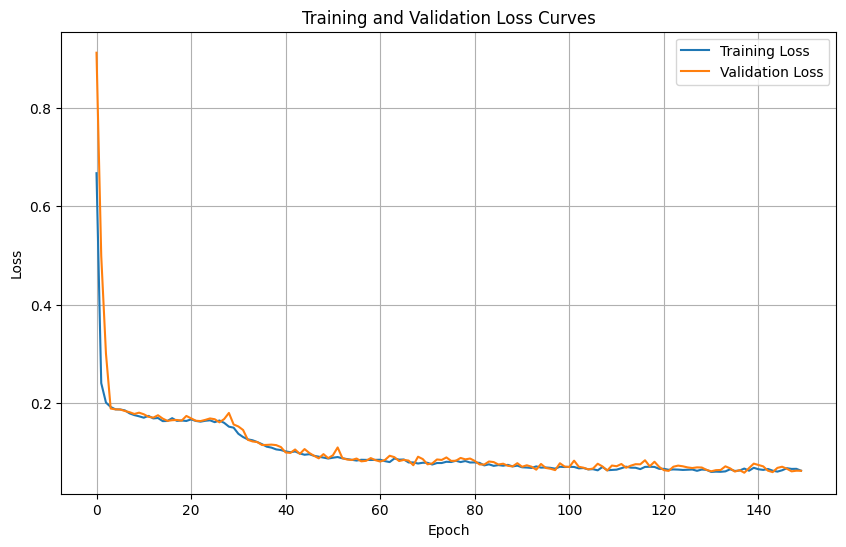

In [ ]:
plot_training_history(history)